# **Book Recommendation System — Collaborative Filtering & Content-Based Approaches**

**Author:** Milos Saric [https://saricmilos.com/]  
**Date:** November 04, 2025 - November 18th, 2025  
**Dataset:** Kaggle — *Book Recommendation Dataset*  

---

This notebook explores the Kaggle Book Recommendation dataset to build intelligent book recommendation systems using both **collaborative filtering** and **content-based** techniques. 
 
**Objective:**  
To develop a personalized **book recommendation system** capable of understanding user preferences and providing meaningful, data-driven suggestions by integrating collaborative and content-based approaches.
The analysis will guide you through the complete data science workflow, including:

1. **Problem Definition** – Define the recommendation goal: predicting user preferences and suggesting books they are most likely to enjoy. Establish appropriate evaluation metrics (Precision@K, Recall@K, RMSE, MAE for ratings prediction).  

2. **Data Collection & Overview** – Load and inspect datasets including `Books`, `Users`, and `Ratings` from Kaggle. Understand data structure, relationships, and key features.  

3. **Exploratory Data Analysis (EDA)** – Analyze rating distributions, user activity, popular books, and correlations between users and items. Visualize key insights through plots.

4. **Data Preprocessing & Feature Engineering** – Clean and merge datasets, handle missing values, normalize user IDs, and extract relevant metadata.  

5. **Model Development** –  
   - **Collaborative Filtering:** User-based and item-based similarity models using cosine correlation. 
   - **Content-Based Filtering:** Use TF-IDF or embeddings on book metadata (titles, authors) to find similar books.  
6. **Evaluation & Testing** – Evaluate recommendation quality using ranking-based metrics. Compare different approaches and interpret the top recommended books for sample users.  

7. **Deployment & Future Work** – Outline strategies to deploy the recommendation engine (via FastAPI).
---

# **About Recommender Systems**

Over the past few decades, platforms like YouTube, Amazon, and Netflix have made recommender systems an essential part of our online experience. Whether it’s suggesting movies to watch, products to buy, or articles to read, these systems help users discover content that matches their interests.

In simple terms, a recommender system is an algorithm that predicts what a user might like based on their preferences and behavior. They play a key role in many industries, not only improving user experience but also driving significant revenue and helping companies stand out from the competition.

---

## **1. Problem Definition**

The first step is to establish a clear understanding of the challenge we aim to solve. This phase lays the groundwork for the entire project and ensures all subsequent efforts remain aligned with the primary objective.

### **Objective**
Develop a **book recommendation system** that predicts and suggests books users are most likely to enjoy, based on their past interactions, ratings, and preferences.  
The system should intelligently recommend books by leveraging techniques such as **collaborative filtering** and **content-based filtering**.

### **Scope**
The analysis focuses on the Kaggle *Book Recommendation Dataset*, which includes three key components:  
- **Users** – demographic and identification information.  
- **Books** – metadata such as titles, authors, and publication details.  
- **Ratings** – explicit user feedback (ratings from 1–10).  

Predictions and recommendations are restricted to the dataset provided, without external sources unless explicitly integrated in advanced phases.

### **Stakeholders**
- **Readers / Users:** Receive personalized book suggestions based on reading habits and preferences.  
- **Publishers & Authors:** Gain insights into reader interests, helping target audiences more effectively.  
- **Data Scientists / ML Practitioners:** Experiment with various recommendation algorithms and performance optimization.  
- **Platform Developers / Businesses:** Improve user engagement, sales, retention, and satisfaction through smarter recommendations.  

### **Success Criteria**
Achieve **high-quality and personalized recommendations**, evaluated using metrics such as:  
- **Precision@K** and **Recall@K** — to measure recommendation relevance.  
- **RMSE / MAE** — for explicit rating prediction accuracy.  

A successful model will deliver **relevant, diverse, and accurate book suggestions** that enhance user experience and foster long-term engagement.

> A clearly defined problem sets the foundation for building a meaningful and effective recommendation system.

## **2. Data Collection**

The **Data Collection** phase focuses on gathering and preparing the datasets required to build and evaluate the book recommendation models. This step also involves importing essential libraries, setting up the working environment, and organizing reusable functions to ensure a smooth analysis workflow.

## **Dataset Description**

The **Book-Crossing Dataset** comprises three main files: **Users**, **Books**, and **Ratings**.  
Each file contains essential information used to build and evaluate the book recommendation system.

---

### **1. Users**

Contains user-related information.  
- **user_id** — Anonymized unique identifier for each user (mapped to integers).  
- **location** — User’s location information (typically “City, State, Country”).  
- **age** — User’s age (if available).  

> Note: Some demographic fields may contain `NaN` values if data was unavailable.

---

### **2. Books**

Contains metadata for each book.  
- **isbn** — Unique book identifier (invalid isbns have already been removed).  
- **book_title** — Title of the book.  
- **book_author** — Author name (only the first author is provided in multi-author cases).  
- **year_of_publication** — Year the book was published.  
- **publisher** — Publishing company.  
- **image_url_s / M / L** — URLs linking to small, medium, and large cover images hosted on Amazon.

> Content-based features such as book titles, authors, and publication years were obtained from **Amazon Web Services**.  

---

### **3. Ratings**

Contains user–book interaction data.  
- **user_id** — References a unique user.  
- **isbn** — References a unique book.  
- **book_rating** — Explicit or implicit feedback:  
  - **1–10** → Explicit ratings (higher values indicate stronger preference).  
  - **0** → Implicit feedback (user has interacted but not rated explicitly).

---

You can access the dataset through the following sources:

- **1.** Download directly from the Github repository: [https://github.com/saricmilos/what-else-should-I-read/tree/main/datasets](https://github.com/saricmilos/what-else-should-I-read/tree/main/datasets)  
- **2.** Download from Kaggle: [Book Recommendation Dataset — Kaggle](https://www.kaggle.com/datasets/arashnic/book-recommendation-dataset/data)  

Both sources provide the same data, so you can use whichever is most convenient for your workflow.

> This dataset serves as the backbone of the recommendation system, enabling the discovery of patterns between users and books, and supporting the development of intelligent, personalized recommendation algorithms.

We can begin by:
1. Loading each dataset (`Users`, `Books`, `Ratings`) individually.  
2. Performing exploratory data analysis (EDA) to understand distributions and missing values.  
3. Merging the datasets to form a unified view of user–book interactions.  
4. Building and evaluating different recommendation approaches. 

### Required Libraries Import

In [1]:
%load_ext autoreload
%autoreload 2

# Modules
from src.dataloader import load_all_csvs_from_folder
from src.preprocess_location import preprocess_location
from src.missing_values import (
    missing_values_heatmap,
    missing_values_barchart,
    get_missing_value_summary
    )
from src.unique_values import (
    get_column_types,
    plot_number_of_unique_values,
    unique_values
    )
from src.plots import (
    plot_top_categories,
    plot_boxplot,
    plot_histogram
    )

In [2]:
# Core
from pathlib import Path
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing
from scipy.sparse import csr_matrix
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_absolute_error, mean_squared_error

We begin by loading our datasets and cleaning column names for consistency.  
Specifically, we:

- Remove leading and trailing spaces
- Convert all names to lowercase
- Replace dashes (`-`) with underscores (`_`)

This makes the DataFrame easier to work with in subsequent analysis.

In [3]:
dataset_folder = Path(r"C:\Users\Milos\Desktop\ESCAPE_9-5\PYTHON\GitHub_Kaggle_Projects\what-else-should-I-read\datasets")

In [4]:
datasets = load_all_csvs_from_folder(dataset_folder)

c:\Users\Milos\Desktop\ESCAPE_9-5\PYTHON\GitHub_Kaggle_Projects\what-else-should-I-read\src\dataloader.py:63: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  datasets[csv_file.stem] = pd.read_csv(csv_file, **read_csv_kwargs)


In [5]:
print(f"{datasets.keys()}")

dict_keys(['Books', 'Ratings', 'Users'])


In [6]:
books_df = datasets.get("Books")
ratings_df = datasets.get("Ratings")
users_df = datasets.get("Users")

We remove leading/trailing spaces, convert all names to lowercase, and replace dashes with underscores. This makes the DataFrame easier to work with in subsequent analysis.


In [7]:
books_df.columns = (
    books_df.columns
    .str.strip()          # Removes leading/trailing spaces
    .str.lower()          # Converts to lowercase
    .str.replace('-', '_')# Replaces dashes with underscores
)

In [8]:
ratings_df.columns = (
    ratings_df.columns
    .str.strip()          # Removes leading/trailing spaces
    .str.lower()          # Converts to lowercase
    .str.replace('-', '_')# Replaces dashes with underscores
)

In [9]:
users_df.columns = (
    users_df.columns
    .str.strip()          # Removes leading/trailing spaces
    .str.lower()          # Converts to lowercase
    .str.replace('-', '_')# Replaces dashes with underscores
)

##  **3. Exploratory Data Analysis (EDA)**

Exploratory Data Analysis is all about **understanding the dataset**, uncovering patterns, spotting anomalies, and generating insights that will guide feature engineering and modeling.

In [10]:
shapes = pd.DataFrame({
    "Dataset": ["books_df", "ratings_df","users_df"],
    "Shape": [books_df.shape, ratings_df.shape,users_df.shape]
})
print(shapes.to_string(index=False))

   Dataset        Shape
  books_df  (271360, 8)
ratings_df (1149780, 3)
  users_df  (278858, 3)


# **3.1. Books Dataset**

### **3.1.1. Basic Information**

In [11]:
original_books_df = books_df

- There are **271,360 book entries** total.
- The `isbn` field has only unique values as rows, meaning each book is uniquely identified by its ISBN.
- `book_title` is *not unique* — only 242,135 unique titles, meaning some books share the same title (likely due to different editions). Selected Poems appear 27 times with different ISBN.
- `book_author` has 102,022 unique names indicating several authors wrote multiple books.
- The `year_of_publication` column has **202 unique years**, with **2002** being the most frequent (13,903 books).
- The `publisher` column has **16,807 unique publishers**, with **Harlequin** being the most common.

In [12]:
books_df.head()

,isbn,book_title,book_author,year_of_publication,publisher,image_url_s,image_url_m,image_url_l
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


In [13]:
books_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271360 entries, 0 to 271359
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   isbn                 271360 non-null  object
 1   book_title           271360 non-null  object
 2   book_author          271358 non-null  object
 3   year_of_publication  271360 non-null  object
 4   publisher            271358 non-null  object
 5   image_url_s          271360 non-null  object
 6   image_url_m          271360 non-null  object
 7   image_url_l          271357 non-null  object
dtypes: object(8)
memory usage: 16.6+ MB


In [14]:
books_df.describe()

,isbn,book_title,book_author,year_of_publication,publisher,image_url_s,image_url_m,image_url_l
count,271360,271360,271358,271360,271358,271360,271360,271357
unique,271360,242135,102022,202,16807,271044,271044,271041
top,0195153448,Selected Poems,Agatha Christie,2002,Harlequin,http://images.amazon.com/images/P/155936078X.0...,http://images.amazon.com/images/P/155936078X.0...,http://images.amazon.com/images/P/155936078X.0...
freq,1,27,632,13903,7535,2,2,2


We can remove columns which contain book covers link images.

In [15]:
books_df

,isbn,book_title,book_author,year_of_publication,publisher,image_url_s,image_url_m,image_url_l
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...
...,...,...,...,...,...,...,...,...
271355,0440400988,There's a Bat in Bunk Five,Paula Danziger,1988,Random House Childrens Pub (Mm),http://images.amazon.com/images/P/0440400988.0...,http://images.amazon.com/images/P/0440400988.0...,http://images.amazon.com/images/P/0440400988.0...
271356,0525447644,From One to One Hundred,Teri Sloat,1991,Dutton Books,http://images.amazon.com/images/P/0525447644.0...,http://images.amazon.com/images/P/0525447644.0...,http://images.amazon.com/images/P/0525447644.0...
271357,006008667X,Lily Dale : The True Story of the Town that Ta...,Christine Wicker,2004,HarperSanFrancisco,http://images.amazon.com/images/P/006008667X.0...,http://images.amazon.com/images/P/006008667X.0...,http://images.amazon.com/images/P/006008667X.0...
271358,0192126040,Republic (World's Classics),Plato,1996,Oxford University Press,http://images.amazon.com/images/P/0192126040.0...,http://images.amazon.com/images/P/0192126040.0...,http://images.amazon.com/images/P/0192126040.0...


In [16]:
book_cover_image_urls = books_df[["image_url_s", "image_url_m", "image_url_l"]]

In [17]:
books_df = books_df.drop(columns= ["image_url_s","image_url_m","image_url_l"])

### **3.1.2. Missing Values Information**

In [18]:
books_df.isna().sum()

isbn                   0
book_title             0
book_author            2
year_of_publication    0
publisher              2
dtype: int64

In [19]:
na_counts_books = books_df.isna().sum().reset_index()
na_counts_books.columns = ['Feature', 'MissingValues']

In [20]:
print(f"{na_counts_books}")

               Feature  MissingValues
0                 isbn              0
1           book_title              0
2          book_author              2
3  year_of_publication              0
4            publisher              2


In [21]:
get_missing_value_summary(books_df)

,Column,Dtype,TotalValues,MissingValues,NonMissingValues,MissingPercent
0,isbn,object,271360,0,271360,0.000000
1,book_title,object,271360,0,271360,0.000000
2,book_author,object,271360,2,271358,0.000737
3,year_of_publication,object,271360,0,271360,0.000000
4,publisher,object,271360,2,271358,0.000737


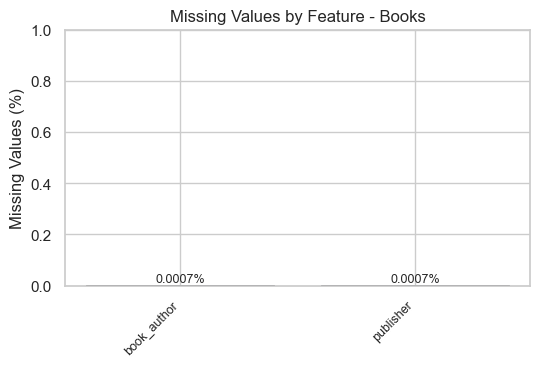

book_author    0.000737
publisher      0.000737
dtype: float64

In [22]:
missing_values_barchart(books_df,"Books")

### **3.1.3. Unique Values Information**

### Book Metadata Overview

The dataset contains **271,360 books**, each described by several key attributes. All attributes are object type. Here’s what we can observe:

- **`isbn`** – Every book has a unique ISBN, which makes it a perfect **unique identifier** for our dataset. 
- **`book_title`** – There are **242,135 unique titles** (about **89%** of total entries). This means most titles are unique, though some duplicates exist — likely due to **different editions or reissues** of the same book.  
- **`book_author`** – Around **102,022 unique authors** are present, meaning each author has, on average, **2–3 books** in the dataset.  
- **`publisher`** – Only **16,807 unique publishers** appear, or roughly **6%** of entries. This makes sense, since **many books come from the same publisher**.  
- **`year_of_publication`** – There are just **202 distinct years**, which is expected because **many books share the same publication year**.

---

Overall, the dataset shows good consistency, **ISBNs are unique**, while other fields naturally repeat due to multiple books by the same authors, publishers, or publication years.


In [23]:
cat_cols_books, int_cols_books, float_cols_books = get_column_types(books_df)

Categorical variables:
['isbn', 'book_title', 'book_author', 'year_of_publication', 'publisher']

Integer variables:
[]

Real (float) variables:
[]


In [24]:
unique_values(books_df)

,Column,UniqueValues,TotalValues,UniquePercent
0,isbn,271360,271360,100.00
1,book_title,242135,271360,89.23
2,book_author,102022,271360,37.60
3,publisher,16807,271360,6.19
4,year_of_publication,202,271360,0.07


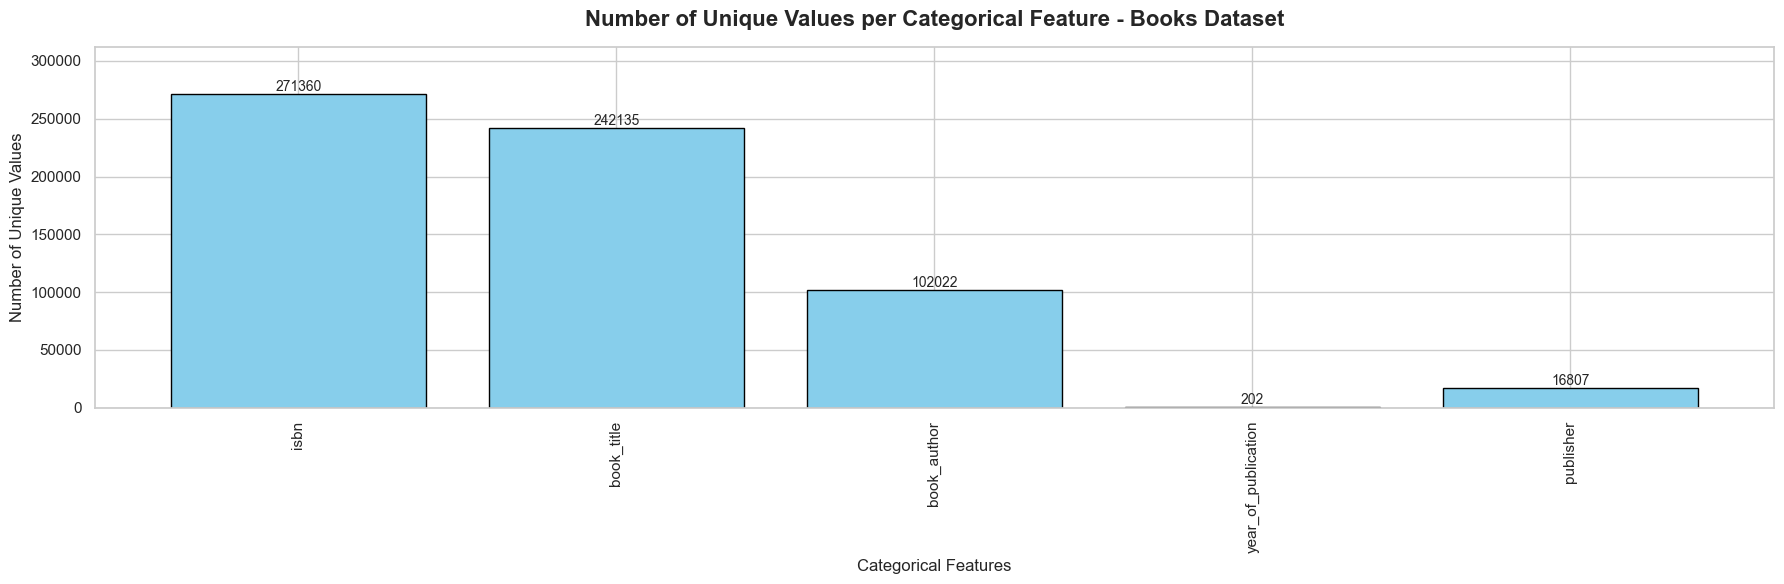

In [25]:
plot_number_of_unique_values(books_df,cat_cols_books,"Books Dataset")

c:\Users\Milos\Desktop\ESCAPE_9-5\PYTHON\GitHub_Kaggle_Projects\what-else-should-I-read\src\plots.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts.values, y=counts.index, palette=palette)


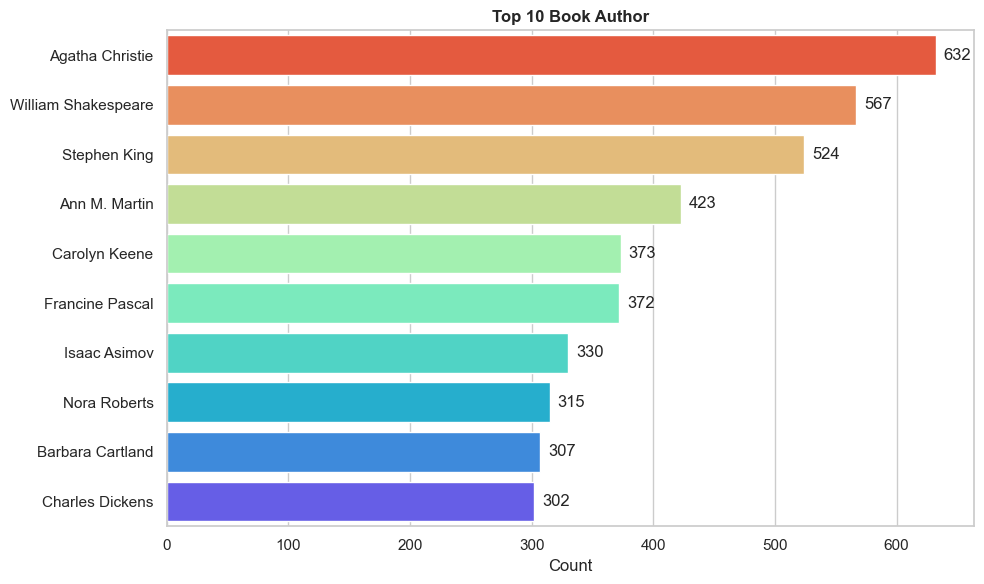

In [26]:
plot_top_categories(books_df, 'book_author', top_n=10, orientation='h', palette='rainbow_r')

c:\Users\Milos\Desktop\ESCAPE_9-5\PYTHON\GitHub_Kaggle_Projects\what-else-should-I-read\src\plots.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts.values, y=counts.index, palette=palette)


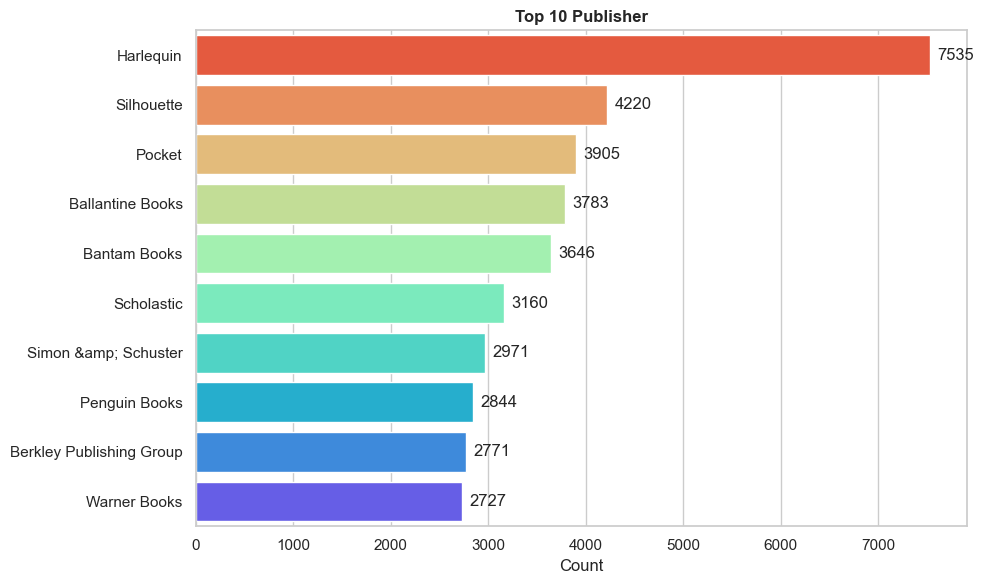

In [27]:
plot_top_categories(books_df, 'publisher', top_n=10, orientation='h', palette='rainbow_r')

# **3.2. Ratings Dataset**

### **3.2.1. Basic Information**

In [28]:
original_ratings_df = ratings_df

Our ratings dataset contains three columns: `user_id`, `isbn`, and `book_rating`, with approximately **1,149,780 entries**.  
There are **no missing values**. The `user_id` column is just an identifier, so statistics like mean or standard deviation are not meaningful.

The `book_rating` column ranges from **0** (book read but not rated) to **10**, with a **mean of 2.87** and a **standard deviation of 3.85**, indicating high variability.  
About **50% of ratings are 0** and **75% are below 7**, showing a **sparse ratings matrix** typical of recommendation datasets.

**Data types:**
- `isbn` → categorical  
- `user_id` → integer  
- `book_rating` → integer  

**Unique values:**
- `isbn`: 340,556 (~30%)  
- `user_id`: 105,283 (~9%)  
- `book_rating`: 11 (0–10)


In [29]:
ratings_df.head()

,user_id,isbn,book_rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [30]:
ratings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1149780 entries, 0 to 1149779
Data columns (total 3 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   user_id      1149780 non-null  int64 
 1   isbn         1149780 non-null  object
 2   book_rating  1149780 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 26.3+ MB


In [31]:
ratings_df.describe()

,user_id,book_rating
count,1.149780e+06,1.149780e+06
mean,1.403864e+05,2.866950e+00
std,8.056228e+04,3.854184e+00
min,2.000000e+00,0.000000e+00
25%,7.034500e+04,0.000000e+00
50%,1.410100e+05,0.000000e+00
75%,2.110280e+05,7.000000e+00
max,2.788540e+05,1.000000e+01


### **3.2.2. Missing Values Information**

Rating Dataframe has NO missing values!

In [32]:
ratings_df.isna().sum()

user_id        0
isbn           0
book_rating    0
dtype: int64

In [33]:
na_counts_ratings = ratings_df.isna().sum().reset_index()
na_counts_ratings.columns = ['Feature', 'MissingValues']

In [34]:
print(f"{na_counts_ratings}")

       Feature  MissingValues
0      user_id              0
1         isbn              0
2  book_rating              0


In [35]:
get_missing_value_summary(ratings_df)

,Column,Dtype,TotalValues,MissingValues,NonMissingValues,MissingPercent
0,user_id,int64,1149780,0,1149780,0.0
1,isbn,object,1149780,0,1149780,0.0
2,book_rating,int64,1149780,0,1149780,0.0


### **3.2.3. Unique Values Information**

In [36]:
cat_cols_ratings, int_cols_ratings, float_cols_ratings = get_column_types(ratings_df)

Categorical variables:
['isbn']

Integer variables:
['user_id', 'book_rating']

Real (float) variables:
[]


In [37]:
unique_values(ratings_df)

,Column,UniqueValues,TotalValues,UniquePercent
0,isbn,340556,1149780,29.62
1,user_id,105283,1149780,9.16
2,book_rating,11,1149780,0.00


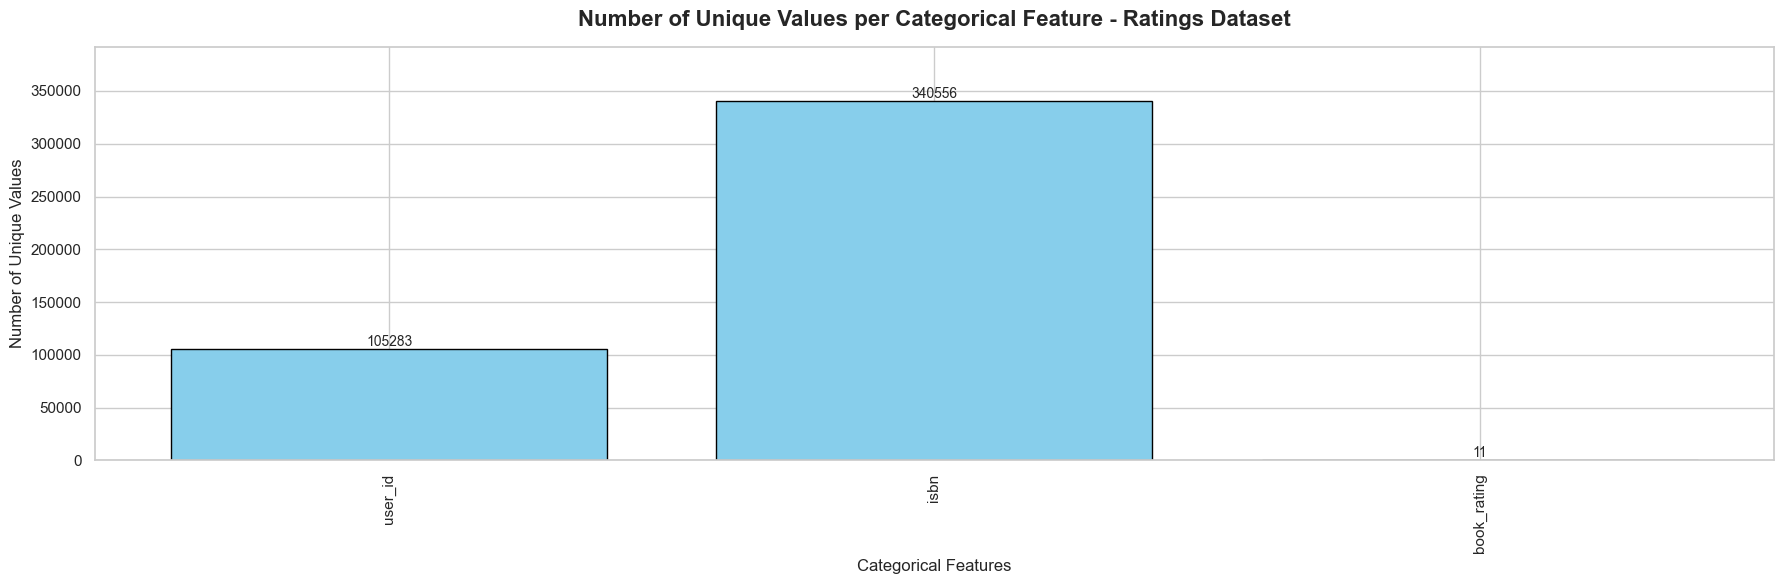

In [38]:
plot_number_of_unique_values(ratings_df,ratings_df.columns,"Ratings Dataset")

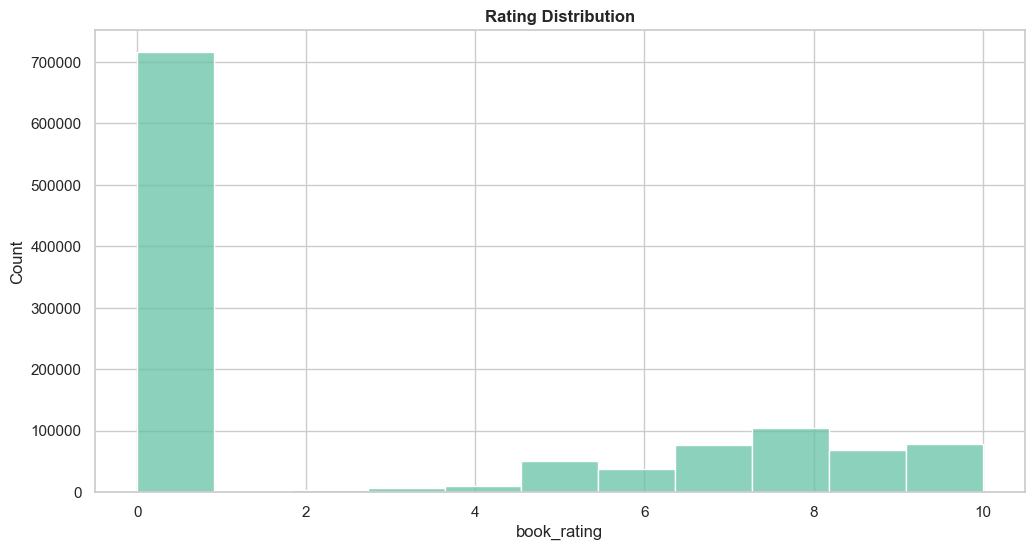

In [39]:
plot_histogram(ratings_df, 'book_rating', bins=11, title='Rating Distribution')

# **3.3. Users Dataset**

### **3.3.1. Basic Information**

In [40]:
original_users_df = users_df

In [41]:
users_df.head()

,user_id,location,age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


We start by preprocessing the `location` column in the user dataset.  
User-entered locations are often messy — with typos, alternate spellings, subregions, or single-entry countries.  
Our goal is to **standardize and simplify** these values.

---

###  Location Preprocessing Functions

- **`split_location(df)`**  
  Splits the `location` column into `city`, `state`, and `country`, trims whitespace, and fills missing values with `'unknown'`.

- **`clean_country(df, country_mapping, region_mapping)`**  
  Standardizes country names, groups rare countries into `'other'`, removes quotes and empty strings, maps each country to a region, and drops the original `country` column.

- **`clean_city(df, top_n=50)`**  
  Cleans city names, replaces invalid or missing entries with `'unknown'`, keeps only the top *N* frequent cities, labels the rest as `'other'`, and drops the original column.

- **`clean_state(df, top_n=50)`**  
  Similar to `clean_city`, but applied to states.

- **`preprocess_location(df, ...)`**  
  Runs all the above steps and returns cleaned columns:  
  `city_clean`, `state_clean`, `country_clean`, and `region`.

---

Overall, this process transforms messy location data into standardized, manageable categories suitable for **analysis or modeling**.


In [42]:
country_mapping = {
    # USA variants
    'usa': 'usa', 'u.s.a.': 'usa', 'us': 'usa', 'america': 'usa', 'u.s.a': 'usa',
    'united states': 'usa', 'united states of america': 'usa', 'united state': 'usa', 
    'united statea': 'usa', 'u.s. of a.': 'usa', 'u.s>': 'usa', 'uusa': 'usa',
    'usa now': 'usa', 'good old usa !': 'usa', 'good old u.s.a.': 'usa',
    'usa (currently living in england)': 'usa', 'usa"': 'usa', 'us virgin islands': 'usa',
    'american samoa': 'usa', 'ca': 'usa', 'nyc': 'usa', 'fl': 'usa', 'tx': 'usa',
    'arizona': 'usa', 'california': 'usa', 'new york': 'usa', 'massachusetts': 'usa',
    'ohio': 'usa', 'colorado': 'usa', 'michigan': 'usa', 'virginia': 'usa',
    'washington': 'usa', 'missouri': 'usa', 'pennsylvania': 'usa', 'illinois': 'usa',
    'nevada': 'usa', 'florida': 'usa', 'north carolina': 'usa', 'south carolina': 'usa',
    'west virginia': 'usa', 'maine': 'usa', 'minnesota': 'usa', 'montana': 'usa',
    'new jersey': 'usa', 'hawaii': 'usa', 'alaska': 'usa', 'texas': 'usa',
    'louisiana': 'usa', 'oh': 'usa', 'nj': 'usa', 'ny': 'usa', 'va': 'usa',
    'pa': 'usa', 'arizona': 'usa', 'florida': 'usa', 'mi': 'usa', 'california': 'usa',
    'anystate': 'usa', 'everywhere and anywhere': 'usa', 'land of the free': 'usa',
    
    # UK variants
    'uk': 'united kingdom', 'u.k.': 'united kingdom', 'england': 'united kingdom',
    'england uk': 'united kingdom', 'united kingdom': 'united kingdom', 'scotland': 'united kingdom',
    'wales': 'united kingdom', 'northern ireland': 'united kingdom',
    
    # Germany variants
    'germany': 'germany', 'deutschland': 'germany', 'germay': 'germany', 'deutsches reich': 'germany',
    'baden-wuerttemberg': 'germany', 'baden-württemberg': 'germany', 'hessen': 'germany',
    'rheinland-pfalz': 'germany', 'bayern': 'germany', 'berlin': 'germany',
    
    # Spain variants
    'spain': 'spain', 'españa': 'spain', 'espana': 'spain', 'espã±a': 'spain', 
    'spain"': 'spain', 'andalucia': 'spain', 'catalunya': 'spain', 'catalonia': 'spain',
    'pais vasco': 'spain', 'valtesse': 'spain', 'laos': 'spain', 'aragon': 'spain',
    
    # Italy variants
    'italy': 'italy', 'italia': 'italy', 'l`italia': 'italy', 'italien': 'italy',
    'italy"': 'italy', 'emilia romagna': 'italy', 'lazio': 'italy', 'sicilia': 'italy',
    'veneto': 'italy', 'toscana': 'italy', 'piemonte': 'italy', 'roma': 'italy', 'milano': 'italy',
    'prov. di milano': 'italy', 'trentino alto adige': 'italy', 'roma': 'italy',
    
    # France variants
    'france': 'france', 'la france': 'france', 'france"': 'france', 'ile de france': 'france',
    'bourgogne': 'france', 'alsace': 'france',
    
    # Portugal variants
    'portugal': 'portugal', 'portugal"': 'portugal', 'alentejo': 'portugal',
    'lisboa': 'portugal', 'porto': 'portugal', 'coimbra': 'portugal', 'azores': 'portugal',
    
    # China variants
    'china': 'china', 'p.r.china': 'china', 'p.r. china': 'china', 'people`s republic of china': 'china',
    'china people`s republic': 'china', 'cn': 'china', 'china"': 'china', 'beijing': 'china',
    'shanghai': 'china', 'liaoning': 'china', 'shanxi province': 'china', 'hubei province': 'china',
    'hunan': 'china', 'guangdong': 'china', 'shandong province': 'china', 'hebei': 'china',
    
    # Australia variants
    'australia': 'australia', 'autralia': 'australia', 'australii': 'australia',
    'australian capital territory': 'australia', 'new south wales': 'australia', 'nsw': 'australia',
    'victoria': 'australia', 'queensland': 'australia', 'western australia': 'australia',
    'south australia': 'australia', 'tasmania': 'australia', 'canberra': 'australia',
    
    # India variants
    'india': 'india', 'india"': 'india', 'maharashtra': 'india', 'maharastra': 'india',
    'jharkhand': 'india', 'punjab': 'india', 'tamil nadu': 'india', 'indiai': 'india',
    
    # Japan variants
    'japan': 'japan', 'japan military': 'japan', 'japan"': 'japan', 'tokyo': 'japan',
    'osaka': 'japan', 'seoul korea': 'japan', 'shizuoka pref.': 'japan',
    
    # Misc / Other countries (examples)
    'canada': 'canada', 'british columbia': 'canada', 'ontario': 'canada', 'newfoundland': 'canada',
    'mexico': 'mexico', 'mexico"': 'mexico', 'ciudad de mexico': 'mexico', 'nuevo leon': 'mexico',
    'venezuela': 'venezuela', 'venezuela"': 'venezuela', 'brazil': 'brazil', 'brasil': 'brazil',
    'brazil"': 'brazil', 'argentina': 'argentina', 'la argentina': 'argentina', 'argentina"': 'argentina',
    'germany"': 'germany', 'deutschland"': 'germany', 'spain"': 'spain',
    'south korea': 'south korea', 'south korea"': 'south korea', 'korea': 'south korea', 's.corea': 'south korea',
    
    # Catch all N/A or unknown
    'n/a': 'unknown', 'n/a"': 'unknown', 'none': 'unknown', 'unknown': 'unknown', '"': 'unknown', '-': 'unknown',
    '.': 'unknown', '*': 'unknown',
}

In [43]:
region_mapping = {
    # North America
    'usa': 'North America',
    'canada': 'North America',
    'mexico': 'North America',
    'bahamas': 'North America',
    'puerto rico': 'North America',
    'bermuda': 'North America',
    'dc': 'North America',
    'oregon': 'North America',  # US state
    'u.s.a': 'North America',
    
    # Central America & Caribbean
    'costa rica': 'Central America',
    'panama': 'Central America',
    'guatemala': 'Central America',
    'jamaica': 'Caribbean',
    'trinidad and tobago': 'Caribbean',
    'dominican republic': 'Caribbean',
    'grenada': 'Caribbean',
    'barbados': 'Caribbean',
    
    # South America
    'brazil': 'South America',
    'argentina': 'South America',
    'chile': 'South America',
    'colombia': 'South America',
    'peru': 'South America',
    'venezuela': 'South America',
    'bolivia': 'South America',
    'uruguay': 'South America',
    'ecuador': 'South America',
    'paraguay': 'South America',
    'urugua': 'South America',  # typo
    
    # Europe
    'united kingdom': 'Europe',
    'germany': 'Europe',
    'spain': 'Europe',
    'italy': 'Europe',
    'france': 'Europe',
    'portugal': 'Europe',
    'netherlands': 'Europe',
    'switzerland': 'Europe',
    'sweden': 'Europe',
    'finland': 'Europe',
    'belgium': 'Europe',
    'ireland': 'Europe',
    'poland': 'Europe',
    'greece': 'Europe',
    'romania': 'Europe',
    'croatia': 'Europe',
    'slovakia': 'Europe',
    'czech republic': 'Europe',
    'russia': 'Europe/Asia',
    'yugoslavia': 'Europe',
    'slovenia': 'Europe',
    'luxembourg': 'Europe',
    'hungary': 'Europe',
    'iceland': 'Europe',
    'andorra': 'Europe',
    'ukraine': 'Europe',
    'lithuania': 'Europe',
    'latvia': 'Europe',
    'malta': 'Europe',
    'albania': 'Europe',
    'macedonia': 'Europe',
    'cyprus': 'Europe',
    'belarus': 'Europe',
    'estonia': 'Europe',
    'austria': 'Europe',
    'austria"': 'Europe',  # in case of trailing quotes
    
    # Asia
    'china': 'Asia',
    'japan': 'Asia',
    'south korea': 'Asia',
    'taiwan': 'Asia',
    'hong kong': 'Asia',
    'india': 'Asia',
    'malaysia': 'Asia',
    'singapore': 'Asia',
    'philippines': 'Asia',
    'indonesia': 'Asia',
    'pakistan': 'Asia',
    'iran': 'Asia',
    'thailand': 'Asia',
    'vietnam': 'Asia',
    'nepal': 'Asia',
    'kazakhstan': 'Asia',
    'afghanistan': 'Asia',
    'brunei': 'Asia',
    'u.a.e': 'Middle East',
    'united arab emirates': 'Middle East',
    'qatar': 'Middle East',
    'kuwait': 'Middle East',
    'bahrain': 'Middle East',
    'oman': 'Middle East',
    'iraq': 'Middle East',
    'sri lanka': 'Asia',
    'burma': 'Asia',
    
    # Africa
    'south africa': 'Africa',
    'ghana': 'Africa',
    'egypt': 'Africa',
    'algeria': 'Africa',
    'kenya': 'Africa',
    'zimbabwe': 'Africa',
    'ethiopia': 'Africa',
    'mozambique': 'Africa',
    'benin': 'Africa',
    'morocco': 'Africa',
    'mauritius': 'Africa',
    
    # Oceania
    'australia': 'Oceania',
    'new zealand': 'Oceania',
    'fiji': 'Oceania',
    
    # Other / Unknown / Misc
    'unknown': 'Unknown',
    'other': 'Unknown',
    'antarctica': 'Other',
    'east africa': 'Africa',
    'caribbean sea': 'Other',
    'euskal herria': 'Europe',  # Basque Country (Spain/France)
}


In [44]:
users_df = preprocess_location(users_df,country_mapping=country_mapping,region_mapping=region_mapping,top_cities= 50,top_states= 50)

In [45]:
users_df = users_df.drop(columns="location")

### User Description

The dataset includes **278,858 total users**, but only **168,096 have a recorded age** — meaning around **110,000 users didn’t provide their age**.

The **average user ID** (139,429.5) doesn’t carry much meaning since it’s just an identifier.  
The **average age** is about **35 years**, with a **standard deviation of roughly 14 years**, suggesting a fairly wide age spread among users.

Looking at the distribution:
- The **youngest recorded age is 0**, which is clearly an invalid or missing entry.  
- **25% of users are younger than 24**, and **half are younger than 32**.  
- **75% of users are younger than 44**, meaning most users fall between their mid-20s and mid-40s.  
- The **maximum recorded age is 244**, which is obviously an outlier or data error.

Overall, the age data contains some missing and unrealistic values, but most users are in the **24–44 age range**, with an average age around **35**.


In [46]:
users_df.head()

,user_id,age,country_clean,region,city_clean,state_clean
0,1,NaN,usa,North America,other,new york
1,2,18.0,usa,North America,other,california
2,3,NaN,russia,Europe/Asia,other,other
3,4,17.0,portugal,Europe,other,other
4,5,NaN,united kingdom,Europe,other,other


In [47]:
users_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278858 entries, 0 to 278857
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   user_id        278858 non-null  int64  
 1   age            168096 non-null  float64
 2   country_clean  278858 non-null  object 
 3   region         278858 non-null  object 
 4   city_clean     278858 non-null  object 
 5   state_clean    278858 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 12.8+ MB


In [48]:
users_df.describe()

,user_id,age
count,278858.00000,168096.000000
mean,139429.50000,34.751434
std,80499.51502,14.428097
min,1.00000,0.000000
25%,69715.25000,24.000000
50%,139429.50000,32.000000
75%,209143.75000,44.000000
max,278858.00000,244.000000


### **3.3.2. Missing Values Information**

Most columns are complete, except for `age`, which has a significant number of missing entries.

In [49]:
users_df.isna().sum()

user_id               0
age              110762
country_clean         0
region                0
city_clean            0
state_clean           0
dtype: int64

In [50]:
na_counts_users = users_df.isna().sum().reset_index()
na_counts_users.columns = ['Feature', 'MissingValues']

In [51]:
print(f"{na_counts_users}")

         Feature  MissingValues
0        user_id              0
1            age         110762
2  country_clean              0
3         region              0
4     city_clean              0
5    state_clean              0


In [52]:
get_missing_value_summary(users_df)

,Column,Dtype,TotalValues,MissingValues,NonMissingValues,MissingPercent
0,user_id,int64,278858,0,278858,0.000000
1,age,float64,278858,110762,168096,39.719857
2,country_clean,object,278858,0,278858,0.000000
3,region,object,278858,0,278858,0.000000
4,city_clean,object,278858,0,278858,0.000000
5,state_clean,object,278858,0,278858,0.000000


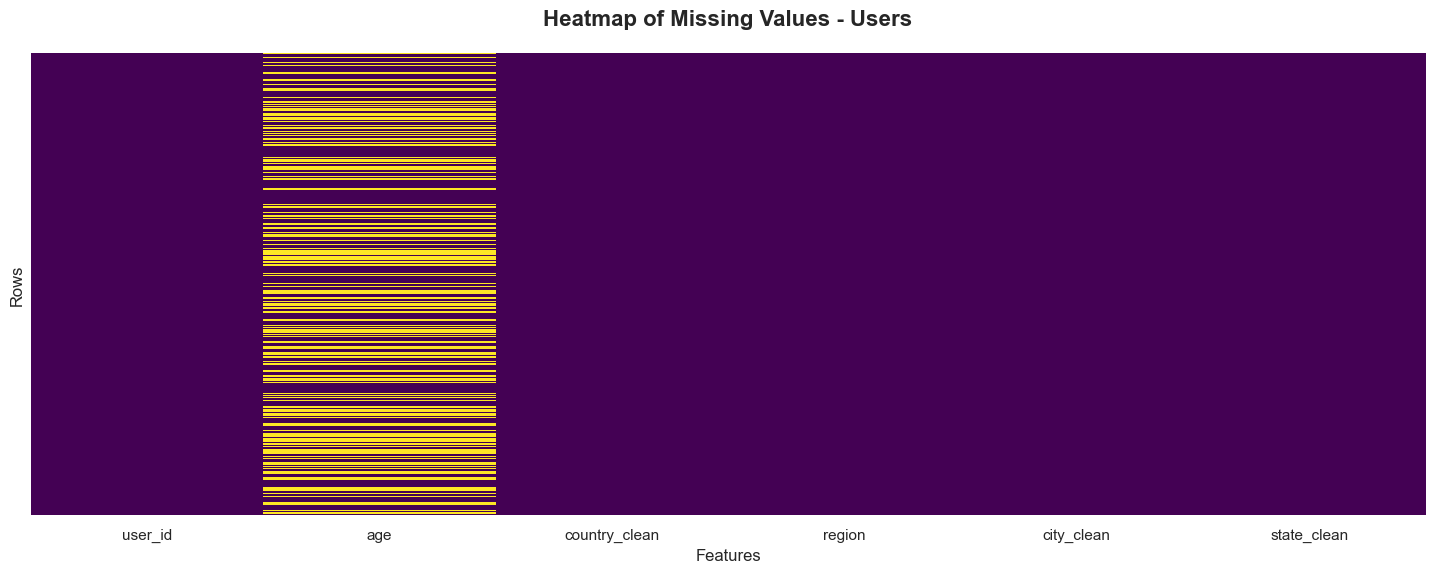

In [53]:
missing_values_heatmap(users_df,"Users")

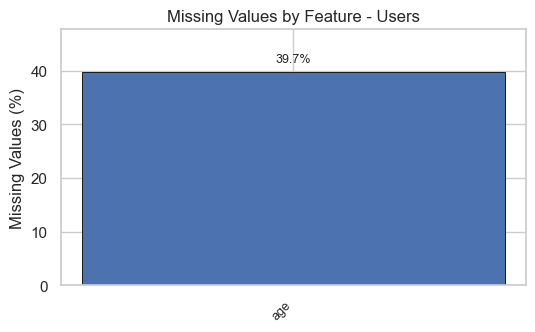

age    39.719857
dtype: float64

In [54]:
missing_values_barchart(users_df,"Users")

In [55]:
users_df[users_df['age'].isnull()]

,user_id,age,country_clean,region,city_clean,state_clean
0,1,NaN,usa,North America,other,new york
2,3,NaN,russia,Europe/Asia,other,other
4,5,NaN,united kingdom,Europe,other,other
6,7,NaN,usa,North America,washington,other
7,8,NaN,canada,North America,other,ontario
...,...,...,...,...,...,...
278849,278850,NaN,italy,Europe,other,lombardia
278853,278854,NaN,usa,North America,portland,oregon
278855,278856,NaN,canada,North America,other,ontario
278856,278857,NaN,usa,North America,other,tennessee


### **3.3.3. Unique Values Information**

- `user_id` is fully unique (100%), serving as a unique identifier for each user.  
- `age` has 165 unique values (~0.06%), indicating outliers.  
- `country_clean` has 131 unique entries (~0.05%), `city_clean` 51 (~0.02%), and `state_clean` 50 (~0.02%).  
- `region` is the least varied with only 13 unique values (~0.00%).  

In [56]:
cat_cols_users, int_cols_users, float_cols_users = get_column_types(users_df)

Categorical variables:
['country_clean', 'region', 'city_clean', 'state_clean']

Integer variables:
['user_id']

Real (float) variables:
['age']


In [57]:
unique_values(users_df)

,Column,UniqueValues,TotalValues,UniquePercent
0,user_id,278858,278858,100.00
1,age,165,278858,0.06
2,country_clean,131,278858,0.05
3,city_clean,51,278858,0.02
4,state_clean,50,278858,0.02
5,region,13,278858,0.00


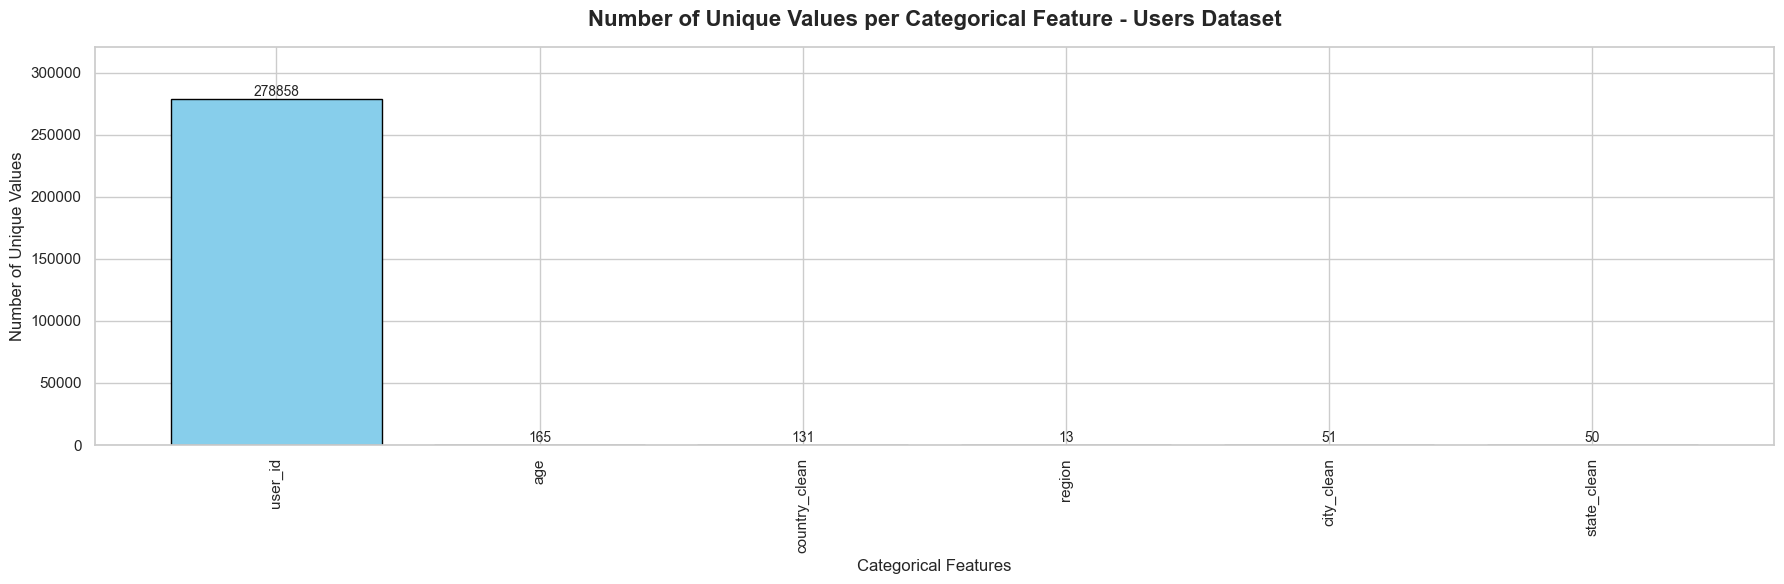

In [58]:
plot_number_of_unique_values(users_df,users_df.columns,"Users Dataset")

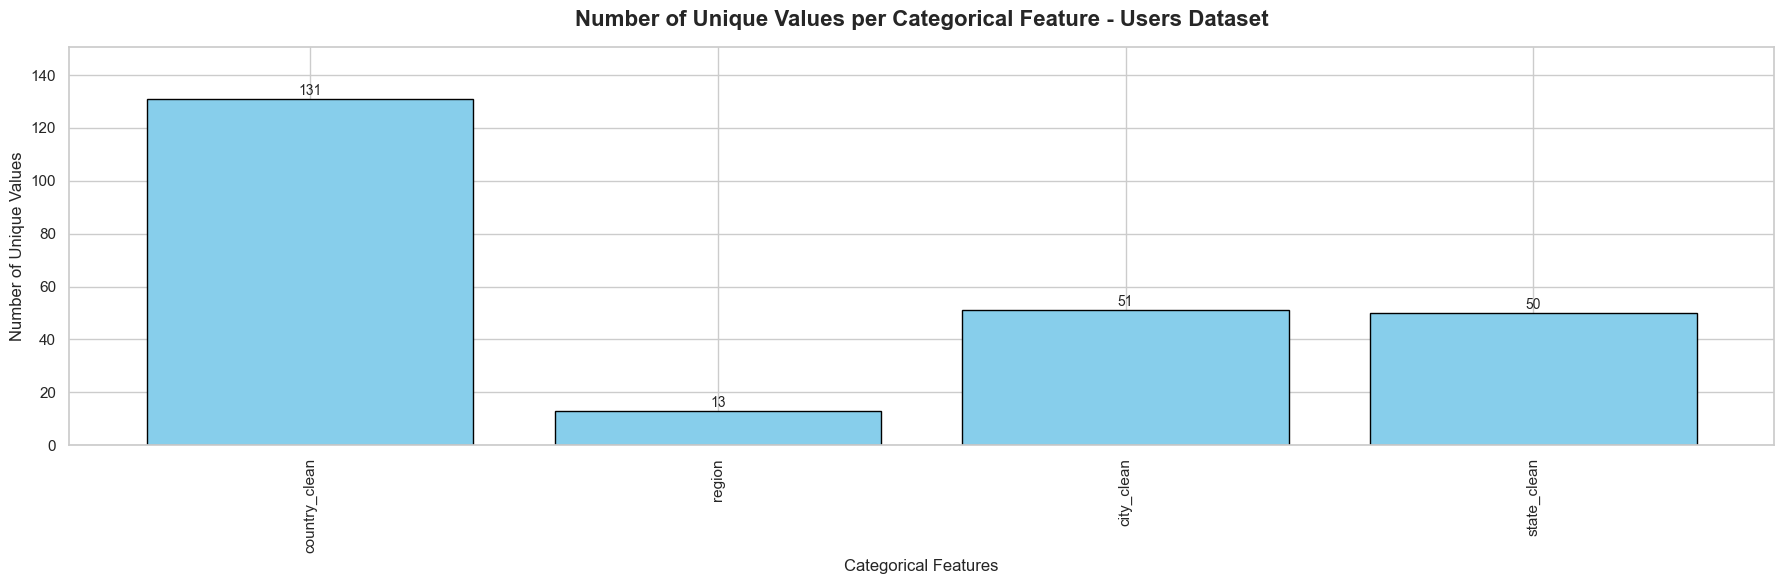

In [59]:
plot_number_of_unique_values(users_df,cat_cols_users,"Users Dataset")

### **3.3.3. Location Information**

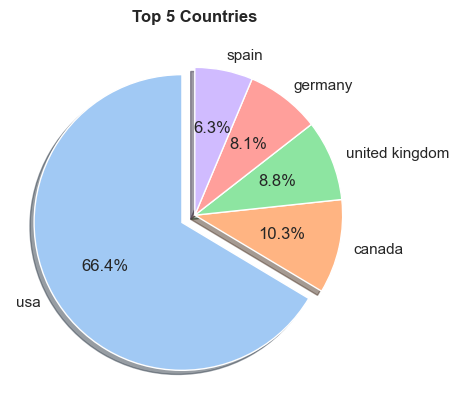

In [60]:
palette_color = sns.color_palette('pastel')
explode = [0.1] + [0]*(min(5, len(users_df['country_clean'].value_counts())) - 1)  # highlight first slice

users_df['country_clean'].value_counts().iloc[:5].plot(
    kind='pie',
    colors=palette_color,
    autopct='%.1f%%',
    explode=explode,
    shadow=True,
    startangle=90
)
plt.title('Top 5 Countries', fontweight='bold')
plt.ylabel('')
plt.show()

C:\Users\Milos\AppData\Local\Temp\ipykernel_12752\3364717479.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y='country_clean', data=users_df,


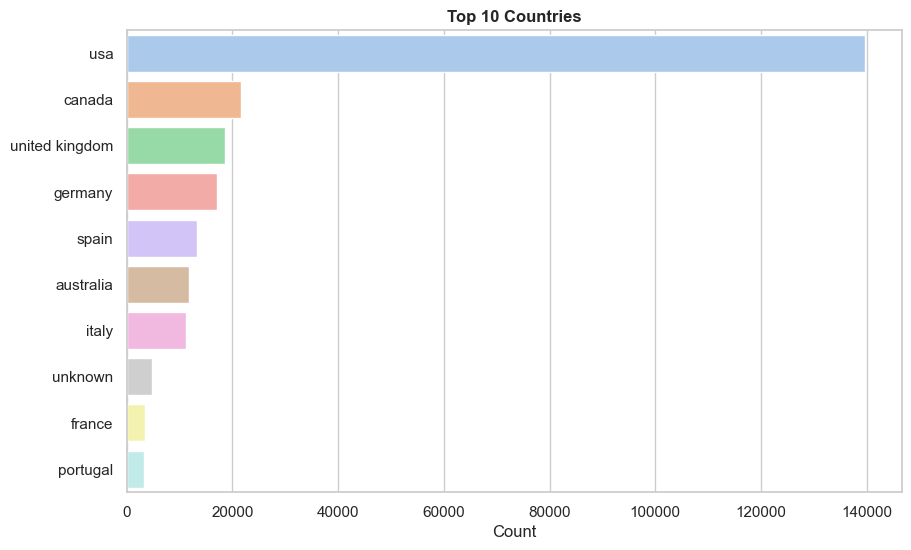

In [61]:
plt.figure(figsize=(10,6))
sns.countplot(y='country_clean', data=users_df,
              order=users_df['country_clean'].value_counts().iloc[:10].index,
              palette='pastel')
plt.title('Top 10 Countries', fontweight='bold')
plt.xlabel('Count')
plt.ylabel('')
plt.show()

In [62]:
users_df['city_clean'].value_counts()

city_clean
other            223321
london             4105
barcelona          2664
toronto            2342
madrid             1933
sydney             1884
portland           1869
melbourne          1863
vancouver          1699
chicago            1566
seattle            1541
new york           1445
milano             1390
san diego          1331
berlin             1306
ottawa             1303
san francisco      1300
houston            1241
paris              1189
roma               1045
austin             1044
los angeles        1042
calgary            1026
hamburg            1003
victoria            874
manchester          838
lisboa              803
singapore           801
christchurch        797
brisbane            792
rome                769
perth               743
edmonton            743
st. louis           726
tucson              685
philadelphia        675
adelaide            665
albuquerque         661
montreal            657
brooklyn            638
richmond            637
dalla

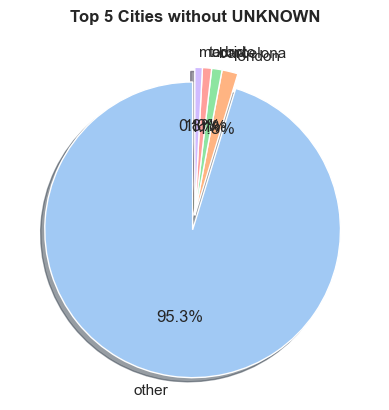

In [63]:
palette_color = sns.color_palette('pastel')
explode = [0.1] + [0]*(min(5, len(users_df['city_clean'].value_counts())) - 1)  # highlight first slice

users_df['city_clean'].value_counts().iloc[:5].plot(
    kind='pie',
    colors=palette_color,
    autopct='%.1f%%',
    explode=explode,
    shadow=True,
    startangle=90
)
plt.title('Top 5 Cities without UNKNOWN', fontweight='bold')
plt.ylabel('')
plt.show()

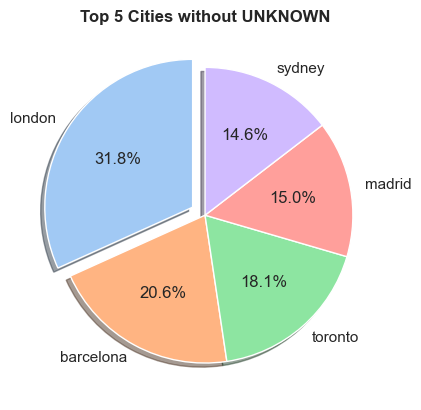

In [64]:
palette_color = sns.color_palette('pastel')
explode = [0.1] + [0]*(min(5, len(users_df['city_clean'].value_counts())) - 1)  # highlight first slice

users_df['city_clean'].value_counts().iloc[1:6].plot(
    kind='pie',
    colors=palette_color,
    autopct='%.1f%%',
    explode=explode,
    shadow=True,
    startangle=90
)
plt.title('Top 5 Cities without UNKNOWN', fontweight='bold')
plt.ylabel('')
plt.show()

C:\Users\Milos\AppData\Local\Temp\ipykernel_12752\2677712999.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y='city_clean', data=users_df,


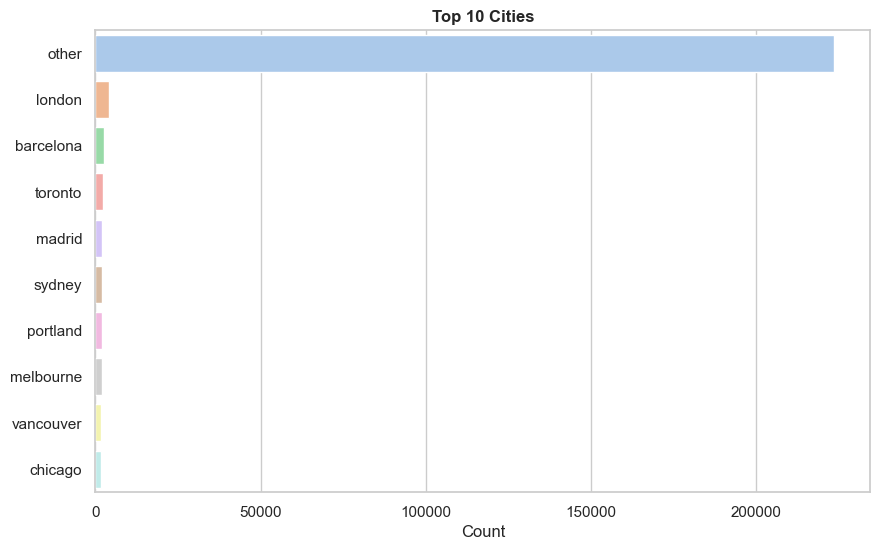

In [65]:
plt.figure(figsize=(10,6))
sns.countplot(y='city_clean', data=users_df,
              order=users_df['city_clean'].value_counts().iloc[:10].index,
              palette='pastel')
plt.title('Top 10 Cities', fontweight='bold')
plt.xlabel('Count')
plt.ylabel('')
plt.show()

C:\Users\Milos\AppData\Local\Temp\ipykernel_12752\387353821.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y='city_clean', data=users_df,


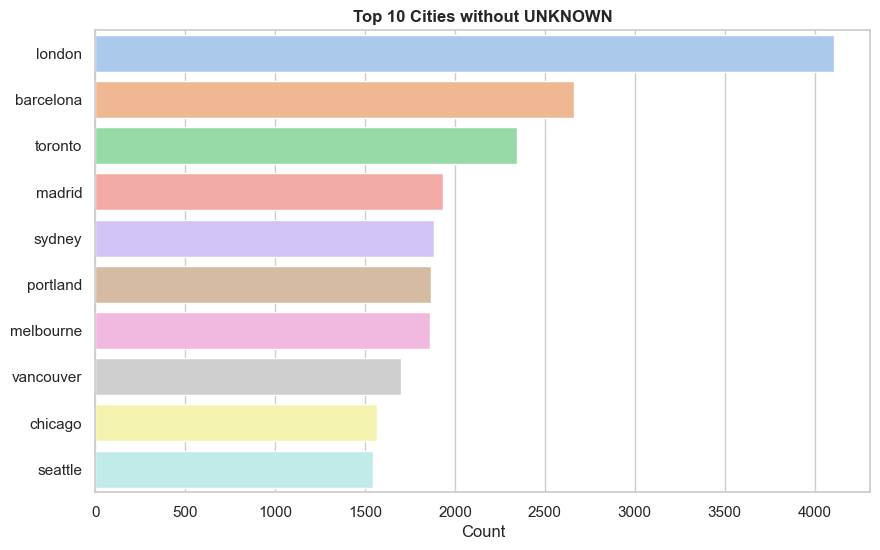

In [66]:
plt.figure(figsize=(10,6))
sns.countplot(y='city_clean', data=users_df,
              order=users_df['city_clean'].value_counts().iloc[1:11].index,
              palette='pastel')
plt.title('Top 10 Cities without UNKNOWN', fontweight='bold')
plt.xlabel('Count')
plt.ylabel('')
plt.show()

# **4. Data Preparation**

# **4.1. Books Dataset**

There are two books with missing authors: "A+ Quiz Masters:01 Earth" (ISBN 0751352497) and "The Credit Suisse
Guide to Managing Your Personal Finances" (ISBN 9627982032). We looked up the correct author information online
and called them as "Dorling Kindersley Publishing Staff" and "Credit Suisse" respectively.

In [67]:
books_df[books_df['book_author'].isnull()]

,isbn,book_title,book_author,year_of_publication,publisher
118033,0751352497,A+ Quiz Masters:01 Earth,NaN,1999,Dorling Kindersley
187689,9627982032,The Credit Suisse Guide to Managing Your Perso...,NaN,1995,Edinburgh Financial Publishing


In [68]:
books_df.loc[books_df['isbn'] == '0751352497', 'book_author'] = 'Dorling Kindersley Publishing Staff'
books_df.loc[books_df['isbn'] == '9627982032', 'book_author'] = 'Credit Suisse'

Similarly, two books had missing publishers: "Tyrant Moon" (ISBN 193169656X) and "Finders Keepers" (ISBN
1931696993). We searched for the correct publishers and updated them to "Mundania Press LLC" and "Random
House Publishing Group."
After these corrections, all books now have complete information for both authors and publishers.

In [69]:
books_df[books_df['publisher'].isnull()]

,isbn,book_title,book_author,year_of_publication,publisher
128890,193169656X,Tyrant Moon,Elaine Corvidae,2002,NaN
129037,1931696993,Finders Keepers,Linnea Sinclair,2001,NaN


In [70]:
books_df.loc[books_df["book_title"]=="Tyrant Moon","publisher"] = "Mundania Press LLC"

In [71]:
books_df.loc[books_df["book_title"]=="Finders Keepers","publisher"] = "Random House Publishing Group"

### Data Quality Issue: `year_of_publication`

The `year_of_publication` column is a mess. It contains a mix of different types of values:

- **Integers** ( `1999`, `2002`)  
- **Strings that look like years** ( `"2000"`, `"1998"`)  
- **Non-year strings**, such as publisher names like `"DK Publishing Inc"`  and `"Gallimard"`  
- **Impossible or invalid years**, such as `0`, `1378`, `1806`, `2030`, and `2050`

Interestingly, when we check for non-digit entries, we only find **about three "bad" rows**, even though there are **65,000+ string values** in total.  
Most of those string entries are actually **numeric strings** (e.g., `"1998"`, `"2003"`, `"0"`), which will need to be converted to integers and cleaned up before analysis.

In [72]:
books_df["year_of_publication"].apply(type).value_counts()

year_of_publication
<class 'int'>    205824
<class 'str'>     65536
Name: count, dtype: int64

In [73]:
books_df[~books_df["year_of_publication"].apply(lambda x: str(x).isdigit())]

,isbn,book_title,book_author,year_of_publication,publisher
209538,078946697X,"DK Readers: Creating the X-Men, How It All Beg...",2000,DK Publishing Inc,http://images.amazon.com/images/P/078946697X.0...
220731,2070426769,"Peuple du ciel, suivi de 'Les Bergers\"";Jean-M...",2003,Gallimard,http://images.amazon.com/images/P/2070426769.0...
221678,0789466953,"DK Readers: Creating the X-Men, How Comic Book...",2000,DK Publishing Inc,http://images.amazon.com/images/P/0789466953.0...


In [74]:
books_df["year_of_publication"].unique()

array([2002, 2001, 1991, 1999, 2000, 1993, 1996, 1988, 2004, 1998, 1994,
       2003, 1997, 1983, 1979, 1995, 1982, 1985, 1992, 1986, 1978, 1980,
       1952, 1987, 1990, 1981, 1989, 1984, 0, 1968, 1961, 1958, 1974,
       1976, 1971, 1977, 1975, 1965, 1941, 1970, 1962, 1973, 1972, 1960,
       1966, 1920, 1956, 1959, 1953, 1951, 1942, 1963, 1964, 1969, 1954,
       1950, 1967, 2005, 1957, 1940, 1937, 1955, 1946, 1936, 1930, 2011,
       1925, 1948, 1943, 1947, 1945, 1923, 2020, 1939, 1926, 1938, 2030,
       1911, 1904, 1949, 1932, 1928, 1929, 1927, 1931, 1914, 2050, 1934,
       1910, 1933, 1902, 1924, 1921, 1900, 2038, 2026, 1944, 1917, 1901,
       2010, 1908, 1906, 1935, 1806, 2021, '2000', '1995', '1999', '2004',
       '2003', '1990', '1994', '1986', '1989', '2002', '1981', '1993',
       '1983', '1982', '1976', '1991', '1977', '1998', '1992', '1996',
       '0', '1997', '2001', '1974', '1968', '1987', '1984', '1988',
       '1963', '1956', '1970', '1985', '1978', '1973', '1980'

To clean up the `year_of_publication` column, we can convert all values to numeric using `pd.to_numeric()` with the `errors='coerce'` parameter.  
This will turn any invalid or non-numeric entries (like publisher names or impossible strings) into `NaN`.


In [75]:
books_df["year_of_publication"] = pd.to_numeric(books_df["year_of_publication"], errors='coerce')

In [76]:
books_df.isna().sum()

isbn                   0
book_title             0
book_author            0
year_of_publication    3
publisher              0
dtype: int64

Replaces invalid years (<1000 or >2025) in `year_of_publication` with NaN.

In [77]:
books_df.loc[
    (books_df["year_of_publication"] < 1000) | 
    (books_df["year_of_publication"] > 2025),
    "year_of_publication"
] = np.nan

Fill missing `year_of_publication` values with the median, then convert the column to integers.


In [78]:
books_df["year_of_publication"].fillna(books_df["year_of_publication"].median(), inplace=True)
books_df["year_of_publication"] = books_df["year_of_publication"].astype(int)

C:\Users\Milos\AppData\Local\Temp\ipykernel_12752\44478353.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  books_df["year_of_publication"].fillna(books_df["year_of_publication"].median(), inplace=True)


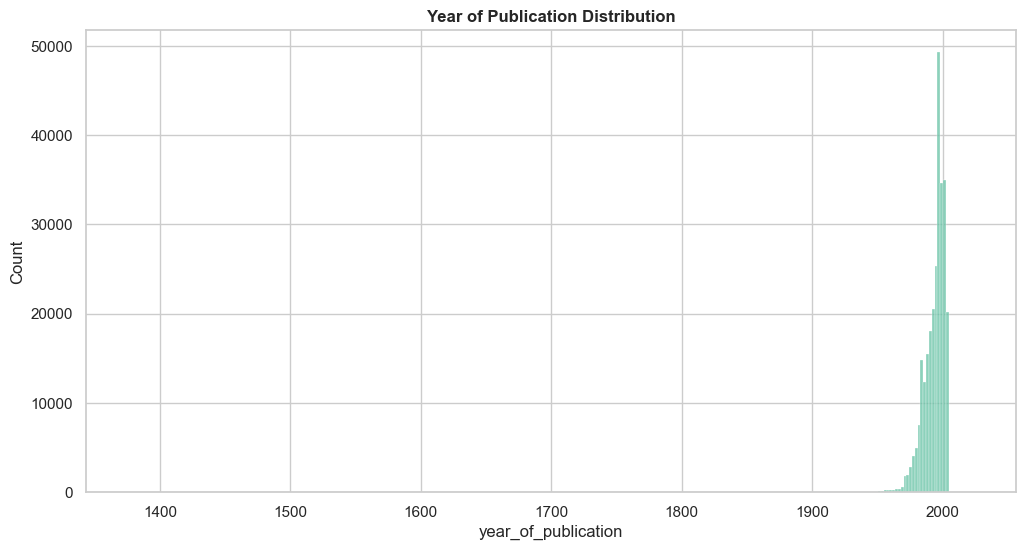

In [79]:
plot_histogram(books_df, 'year_of_publication', bins=300, title='Year of Publication Distribution')

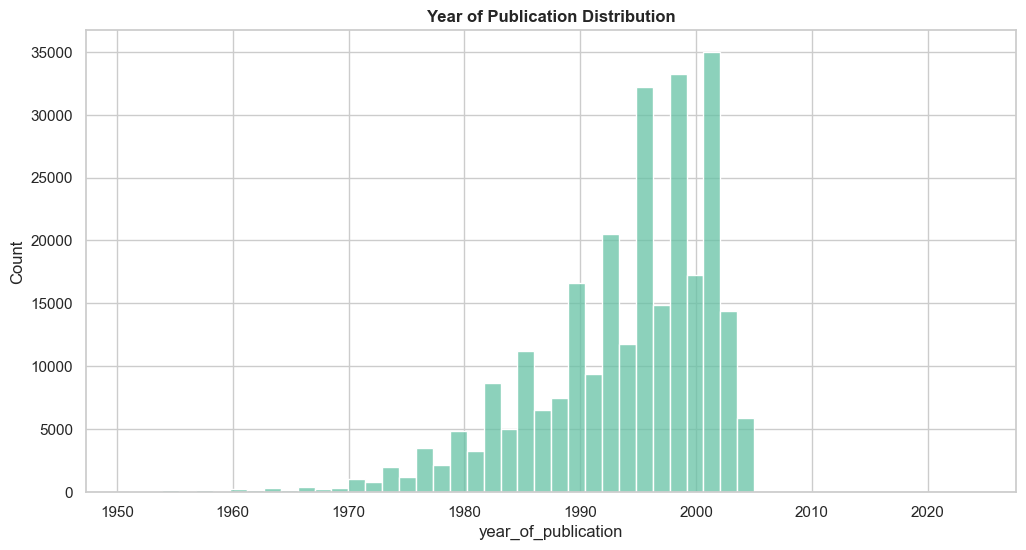

In [80]:
plot_histogram(books_df[books_df["year_of_publication"]>1950], 'year_of_publication', bins=50, title='Year of Publication Distribution')

We can keep only books from 1900

In [81]:
books_df = books_df[books_df['year_of_publication'].between(1900, 2025)]

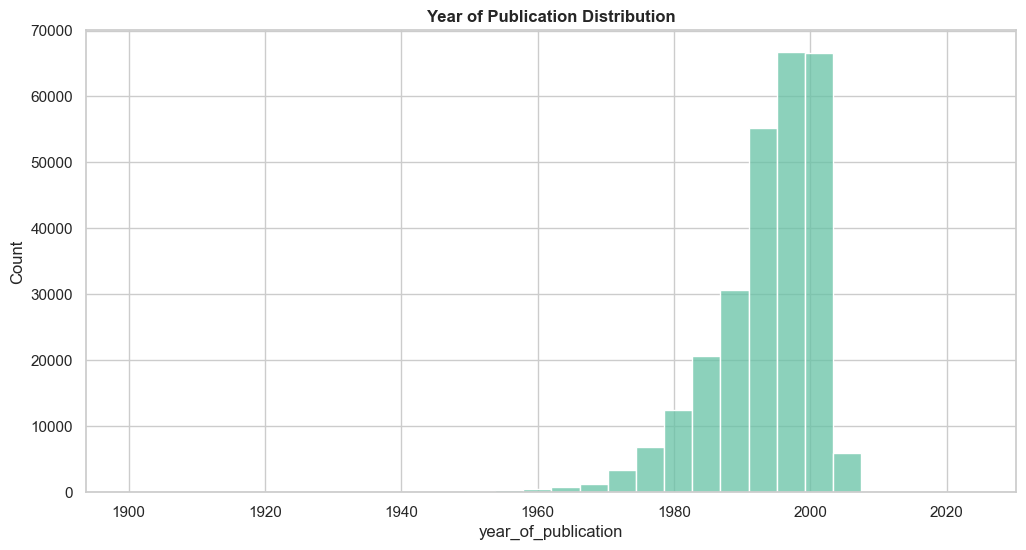

In [82]:
plot_histogram(books_df, 'year_of_publication', bins=30, title='Year of Publication Distribution')

In [83]:
books_df.isna().sum()

isbn                   0
book_title             0
book_author            0
year_of_publication    0
publisher              0
dtype: int64

# **4.2. Ratings Dataset**

In [84]:
ratings_df.isna().sum()

user_id        0
isbn           0
book_rating    0
dtype: int64

In [85]:
ratings_df["book_rating"].apply(type).value_counts()

book_rating
<class 'int'>    1149780
Name: count, dtype: int64

In [86]:
ratings_df["isbn"].apply(type).value_counts()

isbn
<class 'str'>    1149780
Name: count, dtype: int64

In [87]:
ratings_df["user_id"].apply(type).value_counts()

user_id
<class 'int'>    1149780
Name: count, dtype: int64

# **4.3. Users Dataset**

The `age` column is **not normally (Gaussian) distributed** — it is heavily skewed, with many extreme values. Simply relying on the standard Interquartile Range (IQR) method to remove outliers does not work well for this dataset.

- **IQR-based bounds**:  
  - Lower bound: `Q1 - 1.5*IQR = 24 - 30 = -6` → meaningless, leaves many ages as `0` or negative, which are invalid.  
  - Upper bound: `Q3 + 1.5*IQR = 44 + 30 = 74` → too low, would remove valid older users (e.g., 75–99).  

- **Conclusion**: IQR filtering alone is insufficient.  
- **Explicit filtering is needed**: remove ages **below 5** and **above 99** to ensure realistic, meaningful values while keeping the majority of valid data.

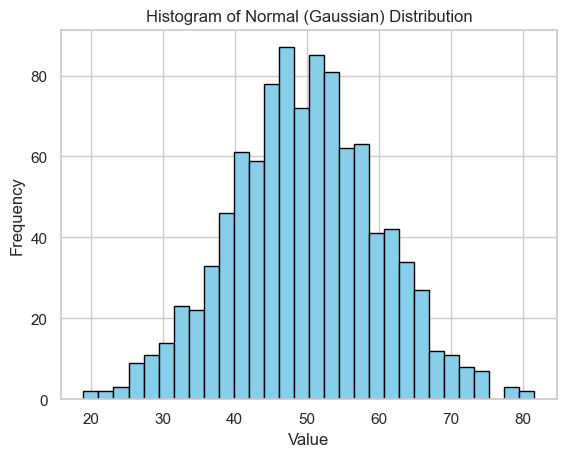

In [88]:
# Generate 1000 random numbers from a normal distribution
mu, sigma = 50, 10  # mean and standard deviation
data = np.random.normal(mu, sigma, 1000)

# Plot histogram
plt.hist(data, bins=30, color='skyblue', edgecolor='black')
plt.title("Histogram of Normal (Gaussian) Distribution")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.show()

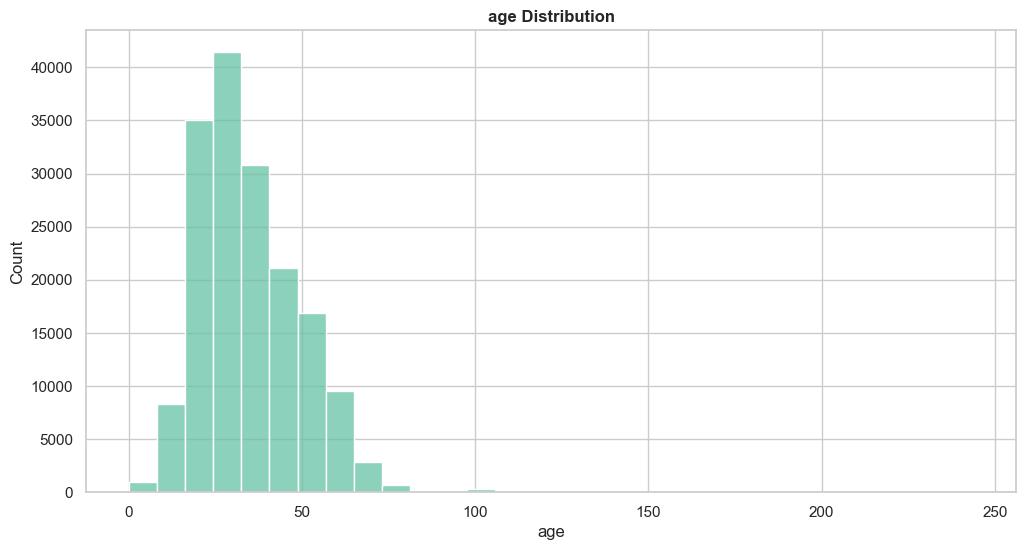

In [89]:
plot_histogram(users_df, 'age', bins=30, title='age Distribution')

c:\Users\Milos\Desktop\ESCAPE_9-5\PYTHON\GitHub_Kaggle_Projects\what-else-should-I-read\src\plots.py:81: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(y=column, data=df, palette=palette)


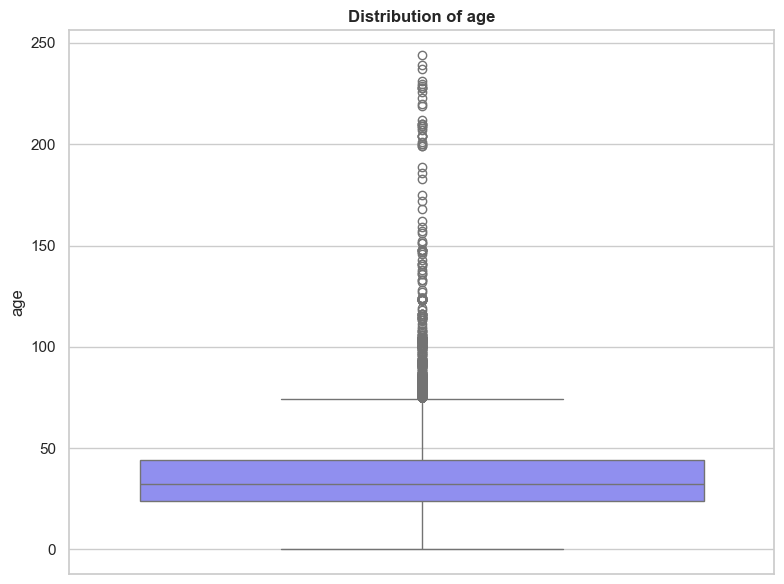

<Axes: title={'center': 'Distribution of age'}, ylabel='age'>

In [90]:
plot_boxplot(users_df, 'age', title='Distribution of age', ylabel='age', palette='cool')

c:\Users\Milos\Desktop\ESCAPE_9-5\PYTHON\GitHub_Kaggle_Projects\what-else-should-I-read\src\plots.py:79: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x=by, y=column, data=df, palette=palette)


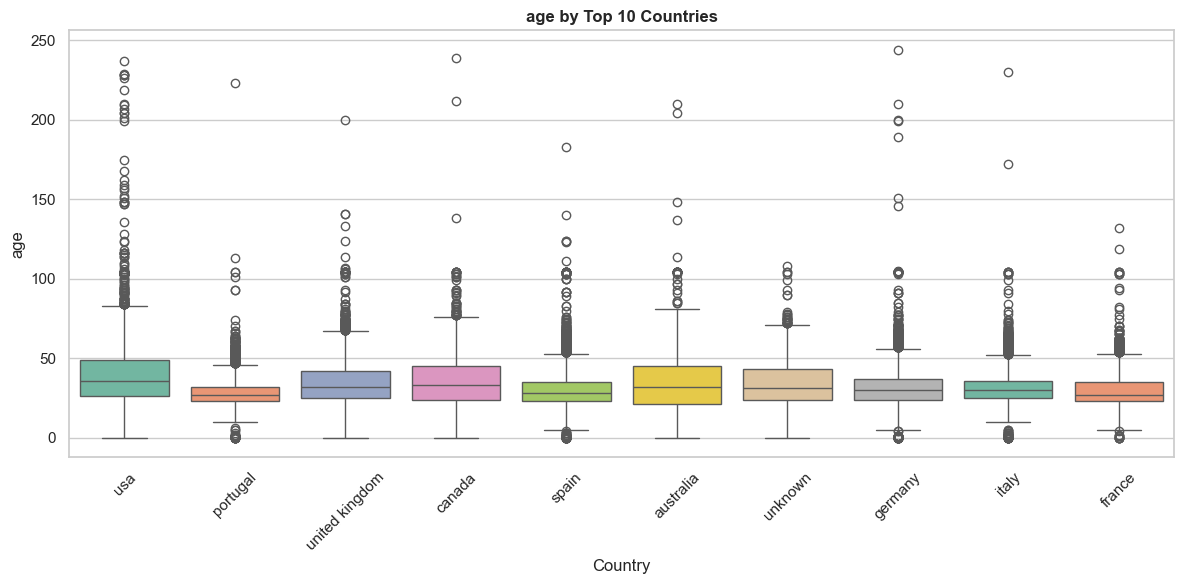

<Axes: title={'center': 'age by Top 10 Countries'}, xlabel='Country', ylabel='age'>

In [91]:
# Get top 10 countries by count
top_countries = users_df['country_clean'].value_counts().nlargest(10).index

# Filter the DataFrame
df_top10 = users_df[users_df['country_clean'].isin(top_countries)]

# Plot only the top 10 countries
plot_boxplot(
    df_top10, 
    column='age', 
    by='country_clean', 
    title='age by Top 10 Countries', 
    ylabel='age', 
    xlabel='Country', 
    palette='Set2', 
    rotate_xticks=True, 
    figsize=(12,6)
)

In [92]:
# Explicitly remove impossible ages
users_df.loc[(users_df['age'] <= 5) | (users_df['age'] > 99), 'age'] = np.nan

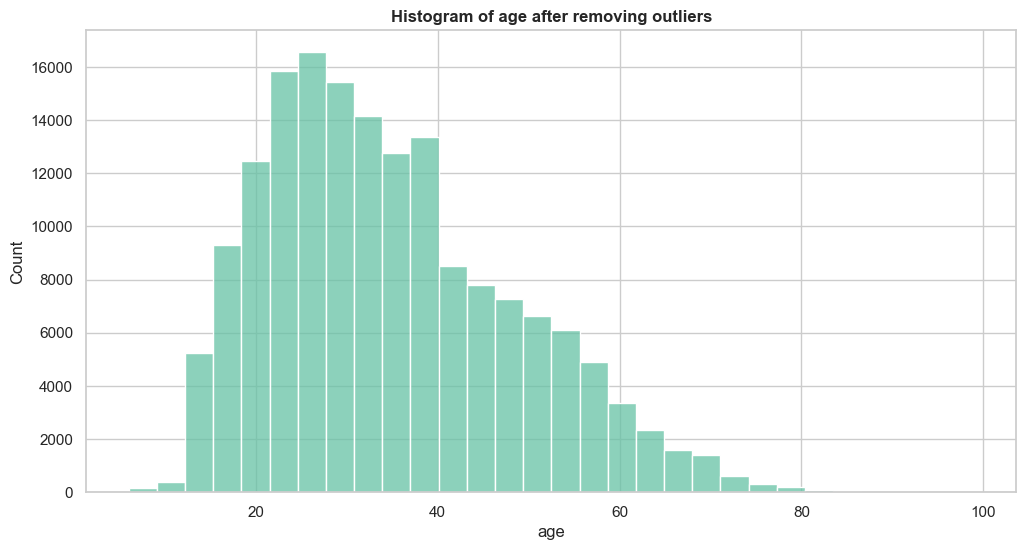

In [93]:
plot_histogram(users_df,"age",bins = 30, title= "Histogram of age after removing outliers")

c:\Users\Milos\Desktop\ESCAPE_9-5\PYTHON\GitHub_Kaggle_Projects\what-else-should-I-read\src\plots.py:81: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(y=column, data=df, palette=palette)


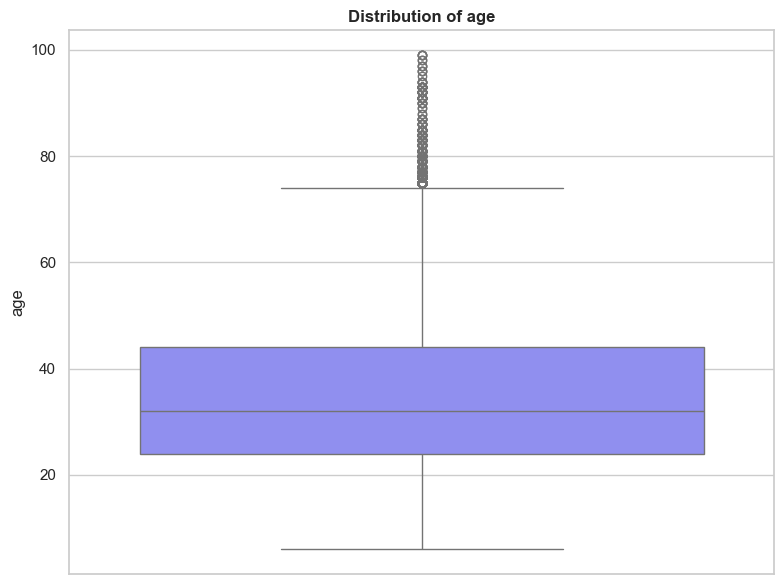

<Axes: title={'center': 'Distribution of age'}, ylabel='age'>

In [94]:
plot_boxplot(users_df, 'age', title='Distribution of age', ylabel='age', palette='cool')

We still have a **large number of missing values**. This shows that **112,043 rows** have missing `age`. Dropping these rows would result in a huge data loss, so we need to **impute** them.



In [95]:
users_df.isna().sum()

user_id               0
age              112043
country_clean         0
region                0
city_clean            0
state_clean           0
dtype: int64

We use a **random imputation method** based on the statistical distribution of the existing ages, median(central tendency of the ages), std (spread of the ages), nulls (total number of missing age values):  

In [96]:
median = users_df['age'].median()
std = users_df['age'].std()
nulls = users_df['age'].isna().sum()

This simulates a realistic age distribution using the existing data, centers the distribution around the median age and ensures the generated ages have a similar spread as the original data and ensures ages are not below 5 or above 100, keeping them realistic:

In [97]:
random_age = np.random.normal(loc=median, scale=std, size=nulls)
random_age = np.clip(random_age, 5, 100)  # limit to plausible range

Assigns the generated random ages to the missing entries and rounds to integer values since age is discrete:

In [98]:
users_df.loc[users_df['age'].isna(), 'age'] = random_age.round().astype(int)

Missing values are replaced with realistic ages, the overall age distribution remains similar to the original data, no extreme outliers are introduced, and all ages fall within the plausible range of 5–100.

# **5. Merge Datasets / Feature Engineering**

Merges `users_df` (278,858 rows, 6 columns) with `ratings_df` (1,149,780 rows, 3 columns) on `user_id`.  
Each row in the result represents a rating with the corresponding user’s info.  

By default, `pd.merge()` does an **inner join**:

- Keeps only `user_id`s present in both dataframes.  
- Users without ratings or ratings without matching users are dropped.

In [99]:
users_ratings=pd.merge(users_df,ratings_df,on='user_id')

When combining datasets, we merge/join on **`isbn`** rather than `book_title`.because **`isbn` is unique**: Each book edition has a distinct ISBN across all tables, and we determined in EDA **`book_title` IS NOT be unique**: Multiple editions of the same book share a title but have different content. Typos, extra spaces, or differences in casing can cause mismatches. **Merging on `book_title` can lead to:**  Duplicate rows, Incorrect joins, Missing records. 

In [100]:
merged_df=pd.merge(users_ratings,books_df,on='isbn')

In [101]:
original_merged_df = merged_df

In [102]:
merged_df.isna().sum()

user_id                0
age                    0
country_clean          0
region                 0
city_clean             0
state_clean            0
isbn                   0
book_rating            0
book_title             0
book_author            0
year_of_publication    0
publisher              0
dtype: int64

C:\Users\Milos\AppData\Local\Temp\ipykernel_12752\4056676647.py:27: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


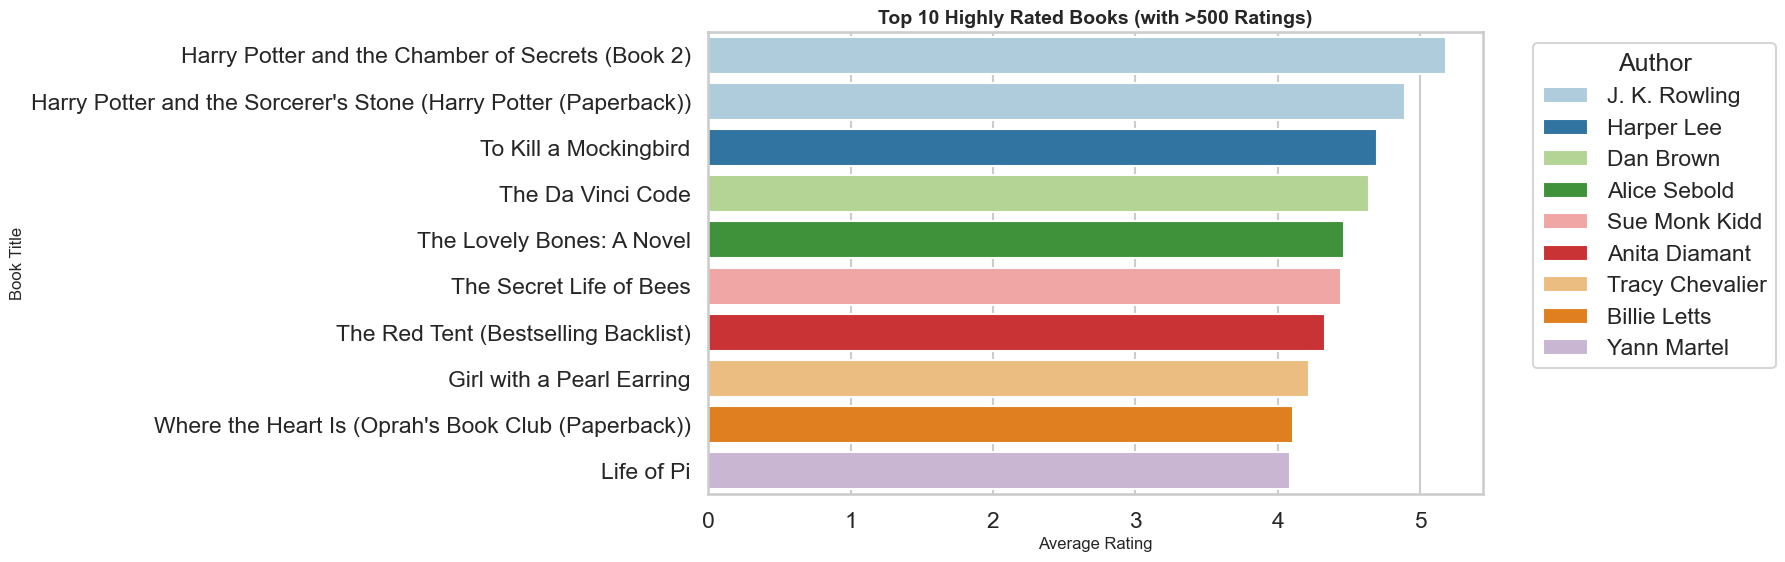

In [103]:
# Aggregate mean and count of ratings per book
book_rating = (
    merged_df.groupby(['book_title', 'book_author'])['book_rating']
    .agg(count='count', mean='mean')
    .reset_index()
)

# Filter to only books with a substantial number of ratings
filtered_books = book_rating.query("count > 500").sort_values('mean', ascending=False).head(10)

# Improve the plot
sns.set(style="whitegrid", context="talk")
plt.figure(figsize=(10, 6))
sns.barplot(
    data=filtered_books,
    x='mean',
    y='book_title',
    hue='book_author',
    palette='Paired',
)

# Labels and title
plt.xlabel('Average Rating', fontsize=12)
plt.ylabel('Book Title', fontsize=12)
plt.title('Top 10 Highly Rated Books (with >500 Ratings)', fontsize=14, fontweight='bold')
plt.legend(title='Author', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


We can remove ratings with a value of `0`, which represent books that users haven’t actually rated.  
However, doing this reduces the number of ratings per book, so some books that originally had more than 500 ratings may now fall below that threshold after these rows are removed.

In [104]:
merged_df = merged_df[merged_df['book_rating']!=0]

C:\Users\Milos\AppData\Local\Temp\ipykernel_12752\2662558729.py:27: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


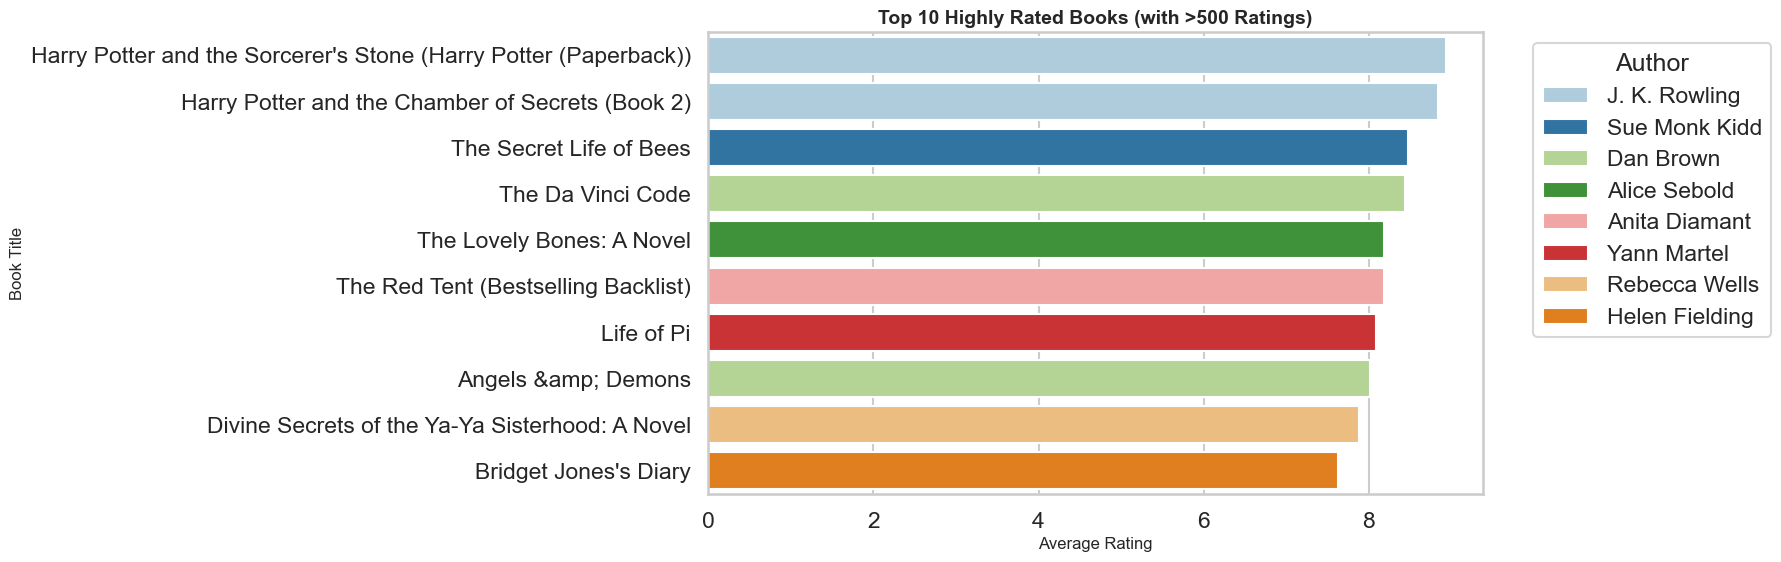

In [105]:
# Aggregate mean and count of ratings per book
book_rating = (
    merged_df.groupby(['book_title', 'book_author'])['book_rating']
    .agg(count='count', mean='mean')
    .reset_index()
)

# Filter to only books with a substantial number of ratings
filtered_books = book_rating.query("count > 300").sort_values('mean', ascending=False).head(10)

# Improve the plot
sns.set(style="whitegrid", context="talk")
plt.figure(figsize=(10, 6))
sns.barplot(
    data=filtered_books,
    x='mean',
    y='book_title',
    hue='book_author',
    palette='Paired',
)

# Labels and title
plt.xlabel('Average Rating', fontsize=12)
plt.ylabel('Book Title', fontsize=12)
plt.title('Top 10 Highly Rated Books (with >500 Ratings)', fontsize=14, fontweight='bold')
plt.legend(title='Author', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


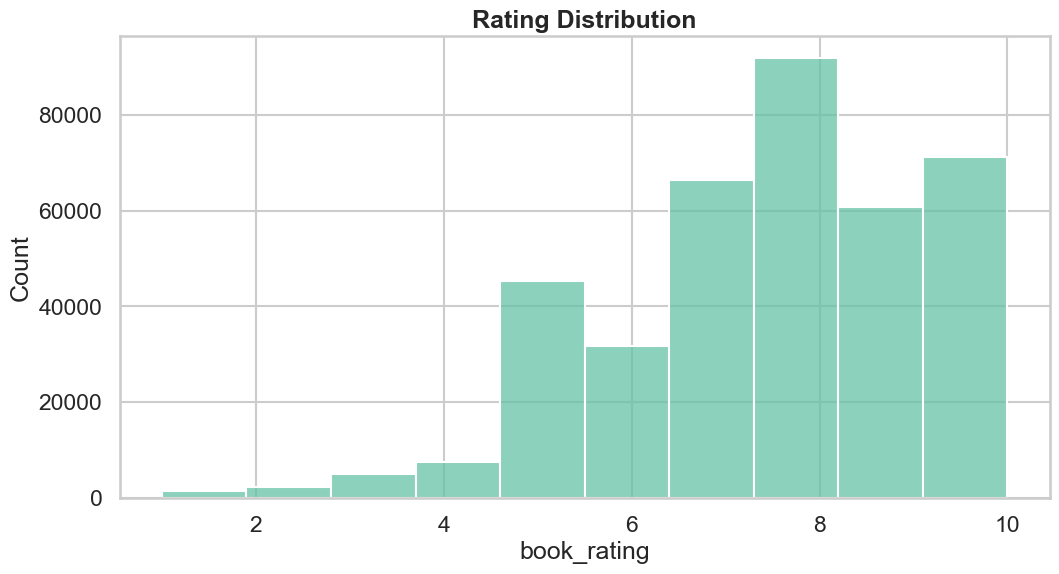

In [106]:
plot_histogram(merged_df, 'book_rating', bins=10, title='Rating Distribution')

# **6. Model Building and Evaluation**

# **6.1. Collaborative Filtering**

For **collaborative filtering (CF)**, we only need the core **user–item interactions**: `user_id`, `isbn` or `book title encoded`, and `book_rating`.  
Other Metadata like user demographics, or book averages aren’t used in standard CF models, though they can be incorporated in **hybrid approaches**.  

CF works by learning **similarity patterns**:  
- Users who rate similar books in similar ways  
- Books that are rated similarly by similar users  

Other columns (age, country, author_avg_rating, etc.) are **side information**. They are useful for:  
- Content-based recommenders  
- Hybrid models combining CF with features  
- Analytics, fairness, or deeper insights  

But for a **pure CF matrix**, only the core user–item-rating data is needed.


### Step 1: filter active users and reasonably-rated books:
New users have no interaction history, so it’s hard to find similar users. New items have few or no ratings, making them difficult to recommend.  

Create new data frame that only consists of user-item ratings

In [107]:
cf_df = merged_df[['user_id', 'book_title', 'book_rating']].copy()

In [110]:
min_user_ratings = 10
min_book_ratings = 10

Groups the dataframe cf_df by each user_id. Count the number of ratings each user has made (how many books they rated).Groups the dataframe by book_title. Counts how many users rated each book.

In [108]:
# Compute user and book counts
user_counts = cf_df.groupby('user_id')['book_rating'].count()
book_counts = cf_df.groupby('book_title')['book_rating'].count()

In [111]:
print(cf_df['user_id'].nunique())  # total users
print(cf_df['book_title'].nunique())  # total books

print(sum(user_counts >= min_user_ratings))  # users meeting threshold
print(sum(book_counts >= min_book_ratings))  # books meeting threshold

68091
135564
6589
5712


Remove very inactive users (who rated too few books) and very unpopular books (with few ratings).This improves collaborative filtering cold start problem and reduces sparsity in the user–item matrix.

In [112]:
active_users = user_counts[user_counts >= min_user_ratings].index
active_books = book_counts[book_counts >= min_book_ratings].index

print(cf_df[cf_df['user_id'].isin(active_users) & cf_df['book_title'].isin(active_books)].shape)

(100819, 3)


In [113]:
cf_df_filtered = cf_df.copy()

while True:
    # Count ratings per user and per book
    user_counts = cf_df_filtered.groupby('user_id')['book_rating'].count()
    book_counts = cf_df_filtered.groupby('book_title')['user_id'].count()
    
    # Keep users and books meeting thresholds
    active_users = user_counts[user_counts >= min_user_ratings].index
    active_books = book_counts[book_counts >= min_book_ratings].index
    
    filtered = cf_df_filtered[
        cf_df_filtered['user_id'].isin(active_users) &
        cf_df_filtered['book_title'].isin(active_books)
    ]
    
    # Stop if dataframe does not change
    if len(filtered) == len(cf_df_filtered):
        break
    
    cf_df_filtered = filtered.copy()

# Final checks
print("Filtered dataframe shape:", cf_df_filtered.shape)
min_ratings_per_user = cf_df_filtered.groupby('user_id')['book_rating'].count().min()
min_ratings_per_book = cf_df_filtered.groupby('book_title')['user_id'].count().min()

print(f"Minimum number of books rated by any user: {min_ratings_per_user}")
print(f"Minimum number of ratings for any book: {min_ratings_per_book}")

Filtered dataframe shape: (56967, 3)
Minimum number of books rated by any user: 10
Minimum number of ratings for any book: 10


### Step 2: Per User Train/Test Split

To evaluate the model realistically, we create a **train/test split for each user**. Each user should have some ratings in the train set (so the model can learn their preferences) and some ratings in the test set (so we can evaluate the recommendations).  

It’s important to make this split **reproducible** by setting a random seed, ensuring consistent results across runs.


1. **Setup**:  
   - `test_frac = 0.2` sets 20% of each user’s ratings for testing.  
   - A fixed random seed (`random_seed = 42`) ensures reproducibility.

2. **Per-user splitting**:  
   - The dataframe is grouped by `user_id`.  
   - For each user, their rating indices are shuffled randomly.  
   - The first `n_test` ratings go to the test set, the rest to the train set.  
   - If a user has only one rating in train or test, it ensures they appear in **both sets** by moving one rating to train if needed.

3. **Build train/test sets**:  
   - `train_df` contains all training ratings.  
   - `test_df` contains all test ratings.  
   - Resetting the index keeps the data clean.

4. **Outcome**:  
   - Every user is present in both train and test.  
   - Train and test rows can now be used to **train the CF model** and **evaluate recommendations** reliably.

The final print statements confirm the number of rows and unique users in each split.

In [114]:
# Parameters
test_frac = 0.2
random_seed = 42
rng = np.random.RandomState(random_seed)

train_idxs = []
test_idxs = []

# group by user and split each user’s ratings
for user, group in cf_df_filtered.groupby('user_id'):
    idxs = group.index.tolist()
    rng.shuffle(idxs)
    
    n_test = max(1, int(round(test_frac * len(idxs))))
    test_for_user = idxs[:n_test]
    train_for_user = idxs[n_test:]
    
    # ensure user appears in train too
    if len(train_for_user) == 0 and len(test_for_user) > 1:
        train_for_user.append(test_for_user.pop())
    
    train_idxs.extend(train_for_user)
    test_idxs.extend(test_for_user)

# Create splits
train_df = cf_df_filtered.loc[train_idxs].reset_index(drop=True)
test_df = cf_df_filtered.loc[test_idxs].reset_index(drop=True)

print("Train rows:", len(train_df))
print("Test rows :", len(test_df))
print("Unique users in train:", train_df['user_id'].nunique())
print("Unique users in test :", test_df['user_id'].nunique())

Train rows: 45592
Test rows : 11375
Unique users in train: 2272
Unique users in test : 2272


In [115]:
# Users
train_users = set(train_df['user_id'])
test_users  = set(test_df['user_id'])
unseen_users = test_users - train_users
print(f"Unseen users in test: {len(unseen_users)}")

# Items
train_items = set(train_df['book_title'])
test_items  = set(test_df['book_title'])
unseen_items = test_items - train_items
print(f"Unseen items in test: {len(unseen_items)}")

Unseen users in test: 0
Unseen items in test: 0


In [116]:
# Create label encoders
user_encoder = preprocessing.LabelEncoder()
item_encoder = preprocessing.LabelEncoder()

# Fit on train set users/items
train_df['user_idx'] = user_encoder.fit_transform(train_df['user_id'])
train_df['book_idx'] = item_encoder.fit_transform(train_df['book_title'])

# Apply same mapping to test set
test_df['user_idx'] = user_encoder.transform(test_df['user_id'])
test_df['book_idx'] = item_encoder.transform(test_df['book_title'])

print("Unique users encoded:", train_df['user_idx'].nunique())
print("Unique books encoded:", train_df['book_idx'].nunique())

Unique users encoded: 2272
Unique books encoded: 2508


# **6.1.1. User Based CF**

### Step 3: Build user-item MATRIX

In [117]:
# Dimensions
num_users = train_df['user_idx'].nunique()
num_items = train_df['book_idx'].nunique()

print(f"Matrix dimensions: {num_users} users x {num_items} books")

# Build sparse matrix
train_matrix = csr_matrix(
    (train_df['book_rating'], 
     (train_df['user_idx'], train_df['book_idx'])),
    shape=(num_users, num_items)
)

Matrix dimensions: 2272 users x 2508 books


We can calculate how sparse the user–item matrix is and shows a small example of it for visualisation:

In [118]:
# Density = proportion of filled ratings
density = train_matrix.count_nonzero() / (num_users * num_items)
print(f"Matrix density: {density:.4f}")

# Show a small dense sample (for inspection only)
train_dense_sample = train_df.pivot_table(
    index='user_idx', columns='book_idx', values='book_rating'
).fillna(0)
train_dense_sample.head()

Matrix density: 0.0079


book_idx,0,1,2,3,4,5,6,7,8,9,...,2498,2499,2500,2501,2502,2503,2504,2505,2506,2507
user_idx,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Step 4: Compute User-User Similarity Using Cosine Similarity (Top-K Neighbors)

In collaborative filtering, each user can be represented as a **vector of their ratings**.  

- The **length of a user vector** is the magnitude of their ratings.  
  - A user who gives many high ratings has a longer vector.  
  - A user who gives few or low ratings has a shorter vector.  

- **Cosine similarity** ignores the vector length and focuses on the **angle between vectors**:  
  - Measures how similar the **pattern of ratings** is between users.  
  - Users with similar preferences across books are considered similar, even if one tends to rate higher or lower overall.  

Using **top-K neighbors**, we focus only on the most similar users when making recommendations.

In [119]:
user_sim_matrix = cosine_similarity(train_matrix)
np.fill_diagonal(user_sim_matrix, 0)  # remove self-similarity

Cosine similarity ranges from 0 (no similarity) to 1 (high similarity). In the heatmap, darker colors represent low similarity (0) and lighter colors represent high similarity (1). Setting the diagonal to 0 removes self-similarity, so users aren’t considered similar to themselves.

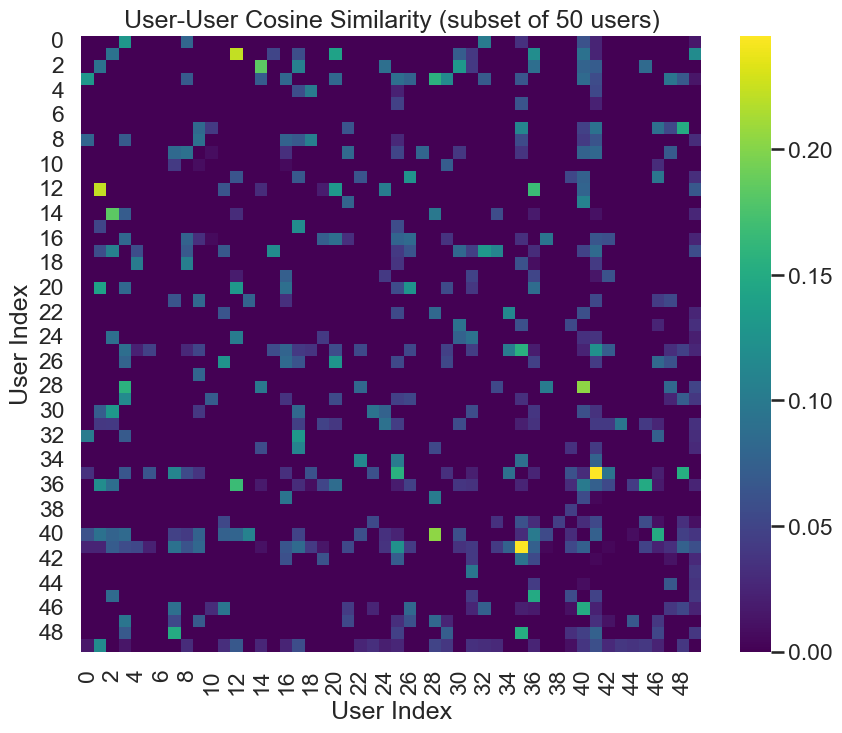

In [120]:
# Take a small subset to visualize (e.g., first 50 users)
subset = user_sim_matrix[:50, :50]

plt.figure(figsize=(10, 8))
sns.heatmap(subset, cmap='viridis')
plt.title("User-User Cosine Similarity (subset of 50 users)")
plt.xlabel("User Index")
plt.ylabel("User Index")
plt.show()

### Step 5: Choose K Nearest Neighbors

For each user, select the **top-K most similar users** from the user-user similarity matrix. These neighbors are used to generate recommendations based on what similar users have rated.

In [121]:
k = 10
top_k_users = np.argsort(-user_sim_matrix, axis=1)[:, :k]

### **Step 6.Predict Ratings**  
   - For each user-item pair, calculate the predicted rating as a weighted average of the ratings from the top-k similar users.  
   - The weights are the similarity scores between the target user and each neighbor.

3. **Normalization**  
   - Normalize by the sum of similarity scores to ensure the predicted ratings are scaled correctly.  
   - If none of the neighbors rated the item, use a fallback such as the user's average rating or the global average.

4. **Build Full Prediction Matrix**  
   - Repeat this process for all users and all items.  
   - Each entry in the matrix represents the estimated rating a user would give to a particular item.

In [122]:
# Compute user means
user_means = np.array(train_matrix.mean(axis=1)).flatten()  # shape: (num_users,)

# Initialize prediction matrix
pred_matrix = np.zeros((num_users, num_items))

# Loop over each user
for u in range(num_users):
    # Top-k similar users
    neighbors = top_k_users[u]
    sim_scores = user_sim_matrix[u, neighbors]  # similarity values
    
    # Neighbor ratings
    neighbor_ratings = train_matrix[neighbors, :].toarray()  # shape (k, num_items)
    
    # Neighbor means
    neighbor_means = user_means[neighbors][:, np.newaxis]  # shape (k, 1)
    
    # Mean-centered ratings
    mean_centered = neighbor_ratings - neighbor_means  # r_vi - bar_r_v
    
    # Weighted sum
    weighted_sum = sim_scores @ mean_centered  # numerator
    sim_sum = np.sum(np.abs(sim_scores))       # denominator
    
    # Add target user mean
    pred_matrix[u, :] = user_means[u] + (weighted_sum / sim_sum if sim_sum != 0 else 0)

# Optional: fill NaNs for safety
pred_matrix = np.nan_to_num(pred_matrix)

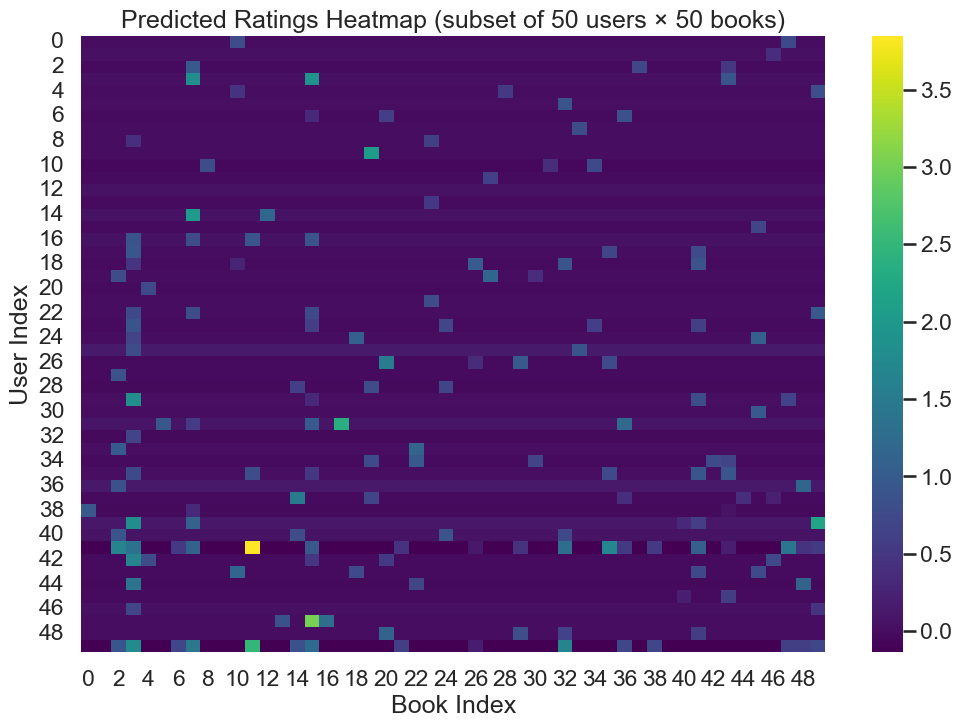

In [123]:
# Take a subset for visualization (e.g., first 50 users and 50 books)
subset = pred_matrix[:50, :50]

plt.figure(figsize=(12, 8))
sns.heatmap(subset, cmap='viridis')
plt.title("Predicted Ratings Heatmap (subset of 50 users × 50 books)")
plt.xlabel("Book Index")
plt.ylabel("User Index")
plt.show()

 **Step 7:Recommendation and Evaluation**  
   - Recommend items to users by selecting those with the highest predicted ratings.  
   - Evaluate the model by comparing predicted ratings to actual ratings in a test set.

In [124]:
def recommend_books_for_user(user_id, pred_matrix, n=5):
    user_ratings = pred_matrix[user_id]
    top_items = np.argsort(-user_ratings)[:n]
    return top_items

In [125]:
top_item_indices = recommend_books_for_user(42, pred_matrix, n=10)

In [126]:
top_books = item_encoder.inverse_transform(top_item_indices)
print(top_books)

["Angela's Ashes: A Memoir" 'Dreamcatcher' 'Tis : A Memoir'
 'The Testament' 'The Da Vinci Code' 'Fall On Your Knees (Oprah #45)'
 '1st to Die: A Novel' 'Temptation' 'The Prince of Tides' 'The Green Mile']


# Evaluating the Recommendation System

The numbers here are not flattering. Precision and recall measure how well the system recommends books users actually like, while MAE, MSE, and RMSE measure how far off the predicted ratings are from the real ones.

Looking at the top-k metrics, Precision@5 is only 0.0542. That means out of the five books the system thinks a user will like most, **on average, only about one in twenty is actually relevant**. Even increasing the recommendations to 20 only raises recall to 0.1116, meaning the system captures barely 11% of items the user actually rated. Precision keeps dropping as k increases, showing that recommending more items mostly adds irrelevant books. This is painfully low, though not surprising given how sparse book rating datasets are.

The rating prediction errors are equally harsh. MAE of 7.3627 and RMSE of 7.6219 indicate that, on average, the predicted rating is off by more than 7 points—absolutely massive if the scale is, for example, 1–10. MSE of 58.0931 highlights that some predictions are catastrophically wrong. These numbers tell us that the model is essentially guessing in most cases. While it might pick up very rough trends, it is **terrible at predicting individual ratings** and fails to produce meaningful recommendations in practice.

In short: this model works just enough to generate numbers, but it’s nowhere near useful for real users. Expect mostly garbage recommendations if deployed as-is.


In [127]:
# True and predicted ratings for the test set
users = test_df['user_idx'].to_numpy()
items = test_df['book_idx'].to_numpy()
y_true = test_df['book_rating'].to_numpy()
y_pred = pred_matrix[users, items]

# Metrics
mae  = mean_absolute_error(y_true, y_pred)
mse  = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)

print(f"MAE  = {mae:.4f}")
print(f"MSE  = {mse:.4f}")
print(f"RMSE = {rmse:.4f}")

MAE  = 7.3627
MSE  = 58.0931
RMSE = 7.6219


In [128]:
def precision_recall_at_n(train_df, test_df, pred_matrix, N=10, threshold=4.0):
    """
    Computes Precision@N and Recall@N for all users.
    threshold: rating threshold above which items are considered 'relevant'
    """
    # Build user → set of items in train/test
    train_items = train_df.groupby('user_idx')['book_idx'].apply(set).to_dict()
    test_items  = (
        test_df[test_df['book_rating'] >= threshold]
        .groupby('user_idx')['book_idx']
        .apply(set)
        .to_dict()
    )
    
    precisions, recalls = [], []
    
    for user, true_items in test_items.items():
        if len(true_items) == 0:
            continue
        
        # Predicted scores for this user
        scores = pred_matrix[user].copy()
        # Exclude training items
        scores[list(train_items.get(user, []))] = -np.inf
        
        # Top-N predicted items
        top_n_items = np.argsort(-scores)[:N]
        
        # Count overlap
        hits = len(set(top_n_items) & true_items)
        precisions.append(hits / N)
        recalls.append(hits / len(true_items))
    
    # Average over all users
    precision_at_n = np.mean(precisions) if precisions else 0.0
    recall_at_n    = np.mean(recalls) if recalls else 0.0
    
    return precision_at_n, recall_at_n

# Example usage:
for N in [5, 10, 20]:
    p, r = precision_recall_at_n(train_df, test_df, pred_matrix, N=N, threshold=4.0)
    print(f"Precision@{N}: {p:.4f} | Recall@{N}: {r:.4f}")

Precision@5: 0.0542 | Recall@5: 0.0632
Precision@10: 0.0383 | Recall@10: 0.0848
Precision@20: 0.0260 | Recall@20: 0.1116


# **6.1.1. Item Based CF**

### Step 3: Build item-user MATRIX

In [134]:

item_user_train_matrix = train_matrix.T

We can calculate how sparse the item-user matrix is and shows a small example of it for visualisation:

In [135]:
# Density = proportion of filled ratings
density = item_user_train_matrix.count_nonzero() / (num_users * num_items)
print(f"Matrix density: {density:.4f}")

# Show a small dense sample (for inspection only)
train_dense_sample = train_df.pivot_table(
    index='book_idx', columns='user_idx', values='book_rating'
).fillna(0)
train_dense_sample.head()

Matrix density: 0.0079


user_idx,0,1,2,3,4,5,6,7,8,9,...,2262,2263,2264,2265,2266,2267,2268,2269,2270,2271
book_idx,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Step 4: Compute Item-Item Similarity Using Cosine Similarity (Top-K Neighbors)

In [136]:
item_sim_matrix = cosine_similarity(item_user_train_matrix)
np.fill_diagonal(item_sim_matrix, 0)  # remove self-similarity

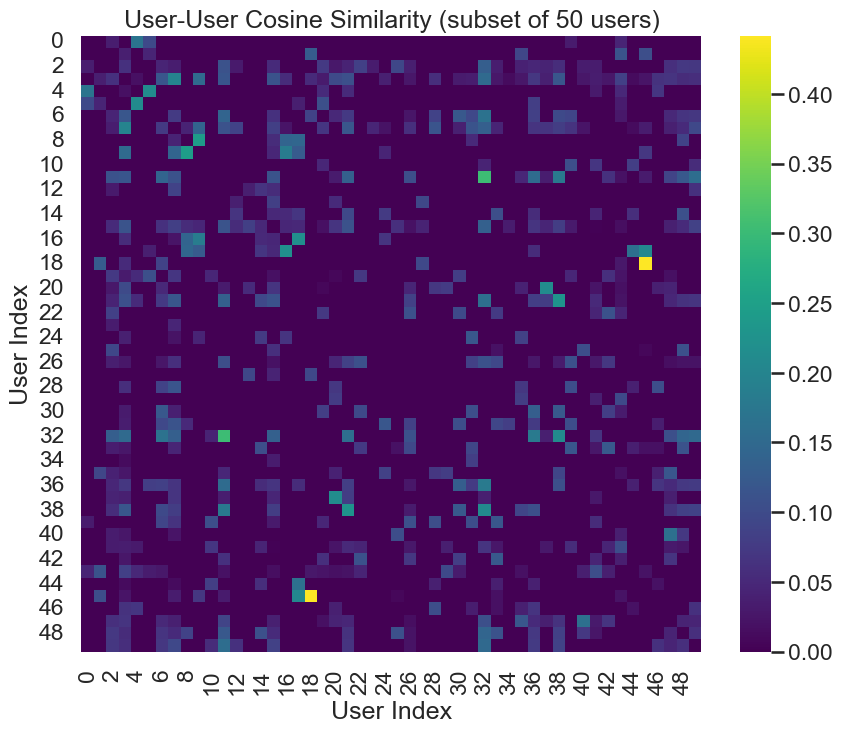

In [138]:
# Take a small subset to visualize (e.g., first 50 users)
subset = item_sim_matrix[:50, :50]

plt.figure(figsize=(10, 8))
sns.heatmap(subset, cmap='viridis')
plt.title("User-User Cosine Similarity (subset of 50 users)")
plt.xlabel("User Index")
plt.ylabel("User Index")
plt.show()

### Step 5: Choose K Nearest Neighbors

In [141]:
k = 10
top_k_items = np.argsort(-item_sim_matrix, axis=1)[:, :k]

**Step 6.Predict Ratings**  

In [145]:
num_items, num_users = item_user_train_matrix.shape

# Compute item means
item_means = item_user_train_matrix.mean(axis=1).A1 if hasattr(item_user_train_matrix, "A1") else np.array(item_user_train_matrix.mean(axis=1)).flatten()

# Initialize prediction matrix (users x items)
item_pred_matrix = np.zeros((num_users, num_items))

# Loop over each item (not user)
for i in range(num_items):
    neighbors = top_k_items[i]             # top-k similar items
    sim_scores = item_sim_matrix[i, neighbors]  # similarity values
    
    # Ratings of all users for neighbor items
    neighbor_ratings = item_user_train_matrix[neighbors, :]  # shape: (k, num_users)
    
    # Neighbor item means
    neighbor_means = item_means[neighbors][:, np.newaxis]   # shape: (k, 1)
    
    # Mean-centered ratings
    mean_centered = neighbor_ratings - neighbor_means       # r_uj - bar_r_j
    
    # Weighted sum: (k x num_users).T -> (num_users,)
    weighted_sum = sim_scores @ mean_centered               # shape: (num_users,)
    sim_sum = np.sum(np.abs(sim_scores))
    
    # Add back item mean
    item_pred_matrix[:, i] = item_means[i] + (weighted_sum / sim_sum if sim_sum != 0 else 0)

# Optional: fill NaNs for safety
item_pred_matrix = np.nan_to_num(item_pred_matrix)

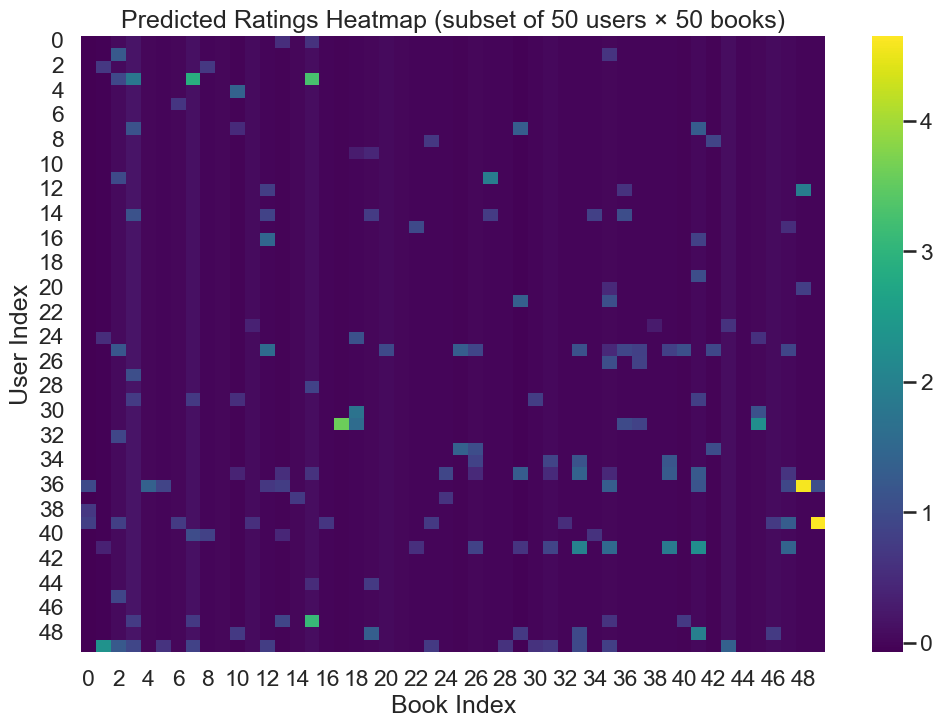

In [146]:
# Take a subset for visualization (e.g., first 50 users and 50 books)
subset = item_pred_matrix[:50, :50]

plt.figure(figsize=(12, 8))
sns.heatmap(subset, cmap='viridis')
plt.title("Predicted Ratings Heatmap (subset of 50 users × 50 books)")
plt.xlabel("Book Index")
plt.ylabel("User Index")
plt.show()

 **Step 7:Recommendation and Evaluation**  

In [156]:
def recommend_books_by_book(book_title, top_k=10):
    # Encode book
    book_idx = item_encoder.transform([book_title])[0]
    
    # Get similarity scores for this book
    sims = item_sim_matrix[book_idx]
    
    # Top-k similar books (excluding the book itself)
    top_k_idx = np.argsort(-sims)[:top_k+1]
    top_k_idx = [i for i in top_k_idx if i != book_idx][:top_k]
    
    # Convert indices back to book titles
    recommended_books = item_encoder.inverse_transform(top_k_idx)
    
    return recommended_books

In [157]:
recommend_books_by_book("The Da Vinci Code")

array(['Angels &amp; Demons', 'Middlesex: A Novel',
       'The Lovely Bones: A Novel', 'Touching Evil',
       'The Secret Life of Bees', 'The Conspiracy Club', 'Street Dreams',
       'Digital Fortress : A Thriller', 'Jennifer Government : A Novel',
       'The Dante Club : A Novel'], dtype=object)

# Evaluating the Item-Based Recommendation System


Looking at the top-N metrics, Precision@5 is only 0.0742, which means that out of the five books recommended to a user, **less than one book on average is actually relevant**. Even when we increase N to 20, the system captures only about 16% of the relevant items in Recall@20. Precision drops as more items are recommended, showing that most of what the system suggests is irrelevant. This slight improvement over the user-based method shows that item-based CF captures some patterns in item similarity, but it is still extremely weak for meaningful recommendations. Sparse user ratings and limited overlap between items are major limiting factors.

The rating prediction errors remain harsh. MAE of 7.1474 and RMSE of 7.4423 indicate that the predicted ratings are still **off by more than 7 points on average**, which is massive if your rating scale is, for example, 1–10. MSE of 55.3873 highlights that some predictions are catastrophically wrong. These numbers suggest that while the item-based method is slightly better at ranking relevant items than user-based CF, it still **fails to predict actual ratings accurately** and would provide mostly useless recommendations if deployed.

In short: item-based CF is a small step forward, but it is still far from usable in practice. Most recommendations are irrelevant, and the predicted ratings are wildly inaccurate.

In [149]:
# True and predicted ratings for the test set
users = test_df['user_idx'].to_numpy()
items = test_df['book_idx'].to_numpy()
y_true = test_df['book_rating'].to_numpy()
y_pred = item_pred_matrix[users, items]

# Metrics
mae  = mean_absolute_error(y_true, y_pred)
mse  = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)

print(f"MAE  = {mae:.4f}")
print(f"MSE  = {mse:.4f}")
print(f"RMSE = {rmse:.4f}")

MAE  = 7.1474
MSE  = 55.3873
RMSE = 7.4423


In [158]:
def precision_recall_at_n_book_to_book(test_df, item_sim_matrix, item_encoder, input_books, N=10, threshold=4.0):
    """
    Computes Precision@N and Recall@N for book-to-book recommendations.
    
    test_df: DataFrame with columns ['user_idx', 'book_idx', 'book_rating']
    item_sim_matrix: item-item similarity matrix
    item_encoder: fitted LabelEncoder for books
    input_books: list of book titles to test
    N: top-N recommendations
    threshold: rating threshold to consider an item relevant
    """
    precisions, recalls = [], []
    
    for book in input_books:
        # Encode input book
        book_idx = item_encoder.transform([book])[0]
        
        # Get similarity scores for this book
        sims = item_sim_matrix[book_idx]
        
        # Top-N recommended items excluding the book itself
        top_n_idx = np.argsort(-sims)[:N+1]
        top_n_idx = [i for i in top_n_idx if i != book_idx][:N]
        
        # Find users who rated this book above threshold in the test set
        relevant_users = set(test_df[(test_df['book_idx'] == book_idx) & 
                                     (test_df['book_rating'] >= threshold)]['user_idx'])
        
        if not relevant_users:
            continue
        
        # For each recommended book, count how many of these relevant users also rated it above threshold
        hits = 0
        for rec_idx in top_n_idx:
            rec_users = set(test_df[(test_df['book_idx'] == rec_idx) & 
                                    (test_df['book_rating'] >= threshold)]['user_idx'])
            hits += len(relevant_users & rec_users)
        
        # Precision = hits / (N * len(relevant_users)) ?
        precisions.append(hits / (N * len(relevant_users)))
        recalls.append(hits / len(relevant_users))
    
    # Average over all input books
    precision_at_n = np.mean(precisions) if precisions else 0.0
    recall_at_n    = np.mean(recalls) if recalls else 0.0
    
    return precision_at_n, recall_at_n

In [160]:
# Example list of books to test
test_books = ["The Hobbit", "Touching Evil", "Pride and Prejudice"]

# Compute Precision@N and Recall@N for these books
precision, recall = precision_recall_at_n_book_to_book(
    test_df=test_df,
    item_sim_matrix=item_sim_matrix,
    item_encoder=item_encoder,
    input_books=test_books,
    N=10,          # top 10 similar books
    threshold=4.0  # consider ratings >= 4 as relevant
)

print(f"Book-to-Book Precision@10: {precision:.4f}")
print(f"Book-to-Book Recall@10: {recall:.4f}")


Book-to-Book Precision@10: 0.0111
Book-to-Book Recall@10: 0.1111


“book-to-user” or “item-to-item recommendation” interface. In essence, you’re doing item-based recommendations, but instead of inputting a user, you input a book name and get similar or complementary books the system predicts you might like.

# **6.2. Content Based Filtering**

For **content-based recommendation**, one-hot encoding works well for columns with **low cardinality**.  

However, for high-cardinality columns like `isbn` (149,833 unique values) or `book_title` (135,564 unique values), traditional one-hot encoding is **impractical**:

- It creates **very large, sparse matrices**  
- Consumes **excessive memory**  
- Slows down computations  

Alternative encoding methods (embeddings, hashing, or TF-IDF for text) are better suited for these cases.

### User Level Features

In [ ]:
# --- USER-LEVEL FEATURES ---

# Average rating given by each user
merged_df['user_avg_rating'] = merged_df.groupby('user_id')['book_rating'].transform('mean')

# Total number of ratings by each user
merged_df['user_num_ratings'] = merged_df.groupby('user_id')['book_rating'].transform('count')

# How consistent a user’s ratings are (standard deviation)
merged_df['User_rating_variability'] = merged_df.groupby('user_id')['book_rating'].transform('std')

# Create a separate dataframe for easy inspection
user_level_features = merged_df[['user_id', 'user_avg_rating', 'user_num_ratings', 'User_rating_variability']].drop_duplicates()

In [ ]:
# --- USER age GROUP FEATURE ---

# Define bins (adjustable) and labels 1–5
age_bins = [0, 18, 25, 35, 50, 100]  # covers ages up to 120
age_labels = [1, 2, 3, 4, 5]         # numeric group codes

# Create a new column
merged_df['User_age_Group'] = pd.cut(
    merged_df['age'],
    bins=age_bins,
    labels=age_labels,
    right=False  # includes the left edge (e.g., 18 goes to group 2)
).astype(int)

In [ ]:
merged_df

### Book Level Features

In [ ]:
# --- BOOK-LEVEL FEATURES ---

# Average rating per book (some books have multiple isbns)
merged_df['book_avg_rating'] = merged_df.groupby('book_title')['book_rating'].transform('mean')

# Number of ratings per book
merged_df['book_num_ratings'] = merged_df.groupby('book_title')['book_rating'].transform('count')

# Standard deviation of ratings per book (optional but insightful)
merged_df['book_rating_variability'] = merged_df.groupby('book_title')['book_rating'].transform('std')

# Optional: Book popularity score (weighted by number of ratings)
merged_df['book_popularity_score'] = merged_df['book_avg_rating'] * np.log1p(merged_df['book_num_ratings'])

# Create a distinct book-level summary DataFrame
book_level_features = merged_df[['book_title', 'book_avg_rating', 'book_num_ratings', 'book_rating_variability', 'book_popularity_score']].drop_duplicates()

In [ ]:
top_books = book_level_features.sort_values('book_num_ratings', ascending=False).head(10)
sns.barplot(x='book_num_ratings', y='book_title', data=top_books, palette='viridis')
plt.title('Top 10 Most Rated Books')
plt.xlabel('Number of Ratings')
plt.ylabel('Book Title')
plt.show()

In [ ]:
merged_df.head()

In [ ]:
merged_df.isna().sum()

In [ ]:
merged_df['User_rating_variability'] = merged_df['User_rating_variability'].fillna(0)
merged_df['book_rating_variability'] = merged_df['book_rating_variability'].fillna(0)

In [ ]:
# --- AUTHOR-LEVEL FEATURE ---
merged_df['author_avg_rating'] = merged_df.groupby('book_author')['book_rating'].transform('mean')

# --- publisher-LEVEL FEATURE ---
merged_df['publisher_avg_rating'] = merged_df.groupby('publisher')['book_rating'].transform('mean')

# --- BOOK age FEATURE ---
# Assuming 'year_of_publication' is numeric and no future years
current_year = 2025
merged_df['book_age'] = current_year - merged_df['year_of_publication']

In [ ]:
merged_df.isna().sum()

In [ ]:
merged_df.head()

### location Based Features

In [ ]:
# --- location-BASED FEATURES ---

# Country-level average rating
merged_df['country_avg_rating'] = merged_df.groupby('country_clean')['book_rating'].transform('mean')

# region-level average rating (if region exists)
merged_df['region_avg_rating'] = merged_df.groupby('region')['book_rating'].transform('mean')

# City-level average rating (optional, more granular)
merged_df['city_avg_rating'] = merged_df.groupby('city_clean')['book_rating'].transform('mean')

# User’s bias compared to their country's average
merged_df['user_country_rating_bias'] = merged_df['user_avg_rating'] - merged_df['country_avg_rating']

# Average rating for each Book within each Country
merged_df['book_country_avg_rating'] = merged_df.groupby(['book_title', 'country_clean'])['book_rating'].transform('mean')

In [ ]:
merged_df.head()

In [ ]:
merged_df.columns

In [ ]:
# # Example for a single top-rated book
# book_name = filtered_books.iloc[0]['book_title']  # top book

# sns.set(style="whitegrid", context="talk")
# plt.figure(figsize=(10, 6))
# sns.scatterplot(
#     data=merged_df[merged_df['book_title'] == book_name],
#     x='age',
#     y='book_rating',
#     alpha=0.6
# )
# sns.regplot(
#     data=merged_df[merged_df['book_title'] == book_name],
#     x='age',
#     y='book_rating',
#     scatter=False,
#     color='red'
# )

# plt.title(f'Age vs Rating for "{book_name}"', fontsize=14, fontweight='bold')
# plt.xlabel('User Age')
# plt.ylabel('Book Rating')
# plt.tight_layout()
# plt.show()

In [ ]:
# sns.scatterplot(data=merged_df, x='age', y='user_avg_rating', alpha=0.4)
# sns.regplot(data=merged_df, x='age', y='user_avg_rating', scatter=False, color='red')
# plt.title('User Age vs Average Rating')
# plt.xlabel('Age')
# plt.ylabel('User Average Rating')
# plt.tight_layout()
# plt.show()


In [ ]:
# sns.scatterplot(data=merged_df.drop_duplicates('isbn'),
#                 x='book_popularity_score', y='book_avg_rating', alpha=0.5)
# sns.regplot(data=merged_df.drop_duplicates('isbn'),
#             x='book_popularity_score', y='book_avg_rating', scatter=False, color='red')
# plt.title('Book Popularity Score vs Average Rating')
# plt.xlabel('Book Popularity Score')
# plt.ylabel('Average Rating')
# plt.tight_layout()
# plt.show()

In [ ]:
# sns.scatterplot(data=merged_df.drop_duplicates('isbn'),
#                 x='book_age', y='book_avg_rating', alpha=0.5)
# sns.regplot(data=merged_df.drop_duplicates('isbn'),
#             x='book_age', y='book_avg_rating', scatter=False, color='red')
# plt.title('Book Age vs Average Rating')
# plt.xlabel('Book Age (years since publication)')
# plt.ylabel('Average Rating')
# plt.tight_layout()
# plt.show()


In [ ]:
merged_df["User_age_Group"].value_counts()

In [ ]:
# # Pivot for heatmap (numeric age groups)
# heatmap_data = (
#     book_age_ratings
#     .pivot(index='book_title', columns='User_age_Group', values='book_rating')
# )

# # Sort rows by one of the numeric columns (e.g., group 1)
# # Make sure the column exists before sorting
# sort_col = 1  # choose any valid numeric group from your data (1–5)
# if sort_col in heatmap_data.columns:
#     heatmap_data = heatmap_data.sort_values(by=sort_col, ascending=False)
# else:
#     # fallback: sort by overall mean if column missing
#     heatmap_data = heatmap_data.assign(mean_rating=heatmap_data.mean(axis=1)) \
#                                .sort_values('mean_rating', ascending=False) \
#                                .drop(columns='mean_rating')

# # Plot heatmap
# plt.figure(figsize=(12, 7))
# sns.heatmap(heatmap_data, annot=True, cmap='YlGnBu', fmt=".2f")

# plt.title('Average Rating by Numeric Age Group and Book', fontsize=14, fontweight='bold')
# plt.xlabel('User Age Group (numeric)')
# plt.ylabel('Book Title')
# plt.tight_layout()
# plt.show()


In [ ]:
# # Author vs AgeGroup: mean rating
# author_age = (
#     merged_df.groupby(['book_author', 'User_age_Group'])['book_rating']
#     .mean().reset_index()
# )
# heat = author_age.pivot(index='book_author', columns='User_age_Group', values='book_rating')

# # Optional: limit to top authors by number of ratings
# top_authors = merged_df.groupby('book_author')['book_rating'].count().nlargest(40).index
# heat = heat.reindex(top_authors)

# # sort by group 1 if present, otherwise by row mean
# sort_col = 1
# if sort_col in heat.columns:
#     heat = heat.sort_values(by=sort_col, ascending=False)
# else:
#     heat = heat.assign(_mean=heat.mean(axis=1)).sort_values('_mean', ascending=False).drop(columns=['_mean'])

# plt.figure(figsize=(12,8))
# sns.heatmap(heat, annot=True, fmt=".2f", linewidths=.4, cbar_kws={'label':'Avg rating'})
# plt.title('Author vs User Age Group — Average Rating')
# plt.xlabel('User Age Group')
# plt.ylabel('Author')
# plt.tight_layout()
# plt.show()


In [ ]:
# pub_age = (
#     merged_df.groupby(['publisher', 'User_age_Group'])['book_rating']
#     .mean().reset_index()
# )
# heat = pub_age.pivot(index='publisher', columns='User_age_Group', values='book_rating')

# # limit to most prolific publishers
# top_pubs = merged_df.groupby('publisher')['book_rating'].count().nlargest(30).index
# heat = heat.reindex(top_pubs)

# # sort safely
# if 1 in heat.columns:
#     heat = heat.sort_values(by=1, ascending=False)
# else:
#     heat = heat.assign(_mean=heat.mean(axis=1)).sort_values('_mean', ascending=False).drop(columns=['_mean'])

# plt.figure(figsize=(12,8))
# sns.heatmap(heat, annot=True, fmt=".2f", linewidths=.4, cbar_kws={'label':'Avg rating'})
# plt.title('Publisher vs User Age Group — Average Rating')
# plt.xlabel('User Age Group')
# plt.ylabel('Publisher')
# plt.tight_layout()
# plt.show()


In [ ]:
merged_df.head()

In [ ]:
#num_cols = ['age','user_avg_rating','user_num_ratings','User_rating_variability',
  #          'book_avg_rating','book_num_ratings','book_rating_variability',
 #           'book_popularity_score','author_avg_rating','publisher_avg_rating','book_age']
#corr = merged_df[num_cols].corr()

#plt.figure(figsize=(10,8))
#sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', center=0, linewidths=.3)
#plt.title('Correlation Matrix — Numeric Features')
#plt.tight_layout()
#plt.show()


In [ ]:
#country_ratings = merged_df.groupby('country_clean')['book_rating'].mean().sort_values(ascending=False).head(15)
#plt.figure(figsize=(12,6))
#sns.barplot(x=country_ratings.values, y=country_ratings.index)
#plt.title('Average Book Rating by Country')
#plt.xlabel('Average Rating')
#plt.ylabel('Country')
#plt.tight_layout()
#plt.show()

In [ ]:
#plt.figure(figsize=(8,6))
#sns.scatterplot(data=merged_df.drop_duplicates('isbn'), x='book_age', y='book_avg_rating', alpha=0.5)
#sns.regplot(data=merged_df.drop_duplicates('isbn'), x='book_age', y='book_avg_rating', scatter=False, color='red')
#plt.title('Book Age vs. Average Rating')
#plt.xlabel('Book Age (Years)')
#plt.ylabel('Average Rating')
#plt.tight_layout()
#plt.show()


### Interaction Based Features

In [ ]:
merged_df['is_high_rating'] = (merged_df['book_rating'] >= 8).astype(int)

In [ ]:
# Rank users by number of ratings
merged_df['user_activity_rank'] = merged_df['user_num_ratings'].rank(method='dense', ascending=False)

In [ ]:
scale_cols = [
    'age',
    'user_avg_rating', 'user_num_ratings', 'User_rating_variability',
    'book_avg_rating', 'book_num_ratings', 'book_rating_variability', 
    'book_popularity_score', 'book_age',
    'author_avg_rating', 'publisher_avg_rating',
    'country_avg_rating', 'region_avg_rating', 'city_avg_rating',
    'user_country_rating_bias', 'book_country_avg_rating'
]

In [ ]:
scaler = MinMaxScaler()
merged_df[scale_cols] = scaler.fit_transform(merged_df[scale_cols])

In [ ]:
merged_df[scale_cols].describe().T[['min', 'max']]

In [ ]:
merged_df

In [ ]:
merged_df.columns

# User based personalized recommendation

In [ ]:
# Count how many ratings each user has made
users_ratings_count_df = merged_df.groupby('user_id')['book_rating'].count()

print(f'Number of users: {len(users_ratings_count_df):,}')

# Filter users with at least 50 ratings
min_ratings = 50
users_with_enough_ratings_df = users_ratings_count_df[users_ratings_count_df >= min_ratings].reset_index()

print(f'Number of users with at least {min_ratings} ratings: {len(users_with_enough_ratings_df):,}')


In [ ]:
merged_df.columns

# ITEM- BASED CF

In [ ]:
# ---------- Assumptions ----------
# train_matrix: scipy.sparse matrix with shape (n_users, n_items)
# test_df: pandas DataFrame with columns ['user_idx', 'book_idx', 'book_rating']
# user_idx and book_idx are zero-based integer indices aligned with train_matrix
# ---------------------------------

# 1) Build item-item similarity (items x items)
item_sim_matrix = cosine_similarity(train_matrix.T)   # shape: (n_items, n_items)
np.fill_diagonal(item_sim_matrix, 0)


In [ ]:
# 2) Precompute top-k neighbors (indices + similarities)
k = 20
top_k_idx = np.argsort(-item_sim_matrix, axis=1)[:, :k]            # (n_items, k)
top_k_sims = np.take_along_axis(item_sim_matrix, top_k_idx, axis=1)  # (n_items, k)


In [ ]:
# 3) Item means (over users) safely
# R: items x users (we will keep this orientation for dot-products)
R = train_matrix.T.toarray()   # items x users
counts = (R != 0).sum(axis=1)
item_mean = np.zeros(R.shape[0], dtype=float)
nonzero = counts > 0
item_mean[nonzero] = R.sum(axis=1)[nonzero] / counts[nonzero]


In [ ]:
# 4) Mean-center only observed ratings; keep missing as 0
R_centered = R - item_mean[:, None]
R_centered[R == 0] = 0   # missing stays 0

In [ ]:
# 5) Predict ratings using only top-k neighbors (vectorized)
# For each item i, neighbors are top_k_idx[i] with sims top_k_sims[i]
n_items, n_users = R.shape
preds = np.zeros((n_items, n_users), dtype=float)

# We'll compute numerator and denom item-by-item (vectorized across users)
for i in range(n_items):
    neigh_idx = top_k_idx[i]       # k neighbors for item i, shape (k,)
    sims = top_k_sims[i]           # shape (k,)
    if np.allclose(sims, 0):
        # no similar neighbors -> fallback to item mean
        preds[i, :] = item_mean[i]
        continue

    # neighbor ratings (k x users)
    neigh_ratings = R_centered[neigh_idx, :]   # shape (k, n_users)

    # weighted sum across neighbors -> numerator (n_users,)
    numerator = sims.dot(neigh_ratings)        # (n_users,)
    denom = np.abs(sims).sum()                 # scalar (sum of |sims| for the k neighbors)

    preds[i, :] = item_mean[i] + numerator / (denom + 1e-8)

# preds is (n_items, n_users). To access predicted rating for (user u, item i): preds[i, u]


In [ ]:
# 6) Evaluate RMSE on test set (make sure to index correctly)
y_true = test_df['book_rating'].values
y_pred = [preds[i, u] for u, i in zip(test_df['user_idx'], test_df['book_idx'])]
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
print(f"RMSE: {rmse:.4f}")


In [ ]:
import numpy as np

def precision_recall_at_n(train_df, test_df, preds, N=10, threshold=4.0):
    precisions, recalls = [], []

    for user in test_df['user_idx'].unique():
        # True relevant items in test (rating >= threshold)
        true_items = test_df[(test_df['user_idx'] == user) & 
                             (test_df['book_rating'] >= threshold)]['book_idx'].values
        if len(true_items) == 0:
            continue

        # Exclude training items
        train_items = train_df[train_df['user_idx'] == user]['book_idx'].values

        # Predicted scores for all items for this user
        scores = preds[:, user].copy()
        scores[train_items] = -np.inf  # mask train items

        # Top-N recommendations
        top_n = np.argsort(-scores)[:N]

        # Compute hits, precision, recall
        hits = len(set(top_n) & set(true_items))
        precisions.append(hits / N)
        recalls.append(hits / len(true_items))

    precision_at_n = np.mean(precisions) if precisions else 0.0
    recall_at_n    = np.mean(recalls) if recalls else 0.0

    return precision_at_n, recall_at_n

# Example usage
for N in [5, 10, 20]:
    p, r = precision_recall_at_n(train_df, test_df, preds, N=N, threshold=4.0)
    print(f"Precision@{N}: {p:.4f} | Recall@{N}: {r:.4f}")


In [ ]:
# 7) Get top-5 book recommendations per user (mask already-seen items)
n_recs = 5
train_dense = train_matrix.toarray()   # shape: (n_users, n_items)
# preds_user_items: users x items
preds_ui = preds.T   # shape: (n_users, n_items)


In [ ]:
# mask seen: set predictions for items user already rated to -inf so they won't be recommended
mask = (train_dense > 0)
preds_ui_masked = preds_ui.copy()
preds_ui_masked[mask] = -np.inf

# get top-n indices for each user
top_n_idx_per_user = np.argsort(-preds_ui_masked, axis=1)[:, :n_recs]   # (n_users, n_recs)


In [ ]:
# Example: for user 0 recommended book indices:
# recommended_books_for_user0 = top_n_idx_per_user[0]

# Build a dict or DataFrame of recommendations if you want
user_ids = np.arange(preds_ui_masked.shape[0])
recommendations = {u: top_n_idx_per_user[u].tolist() for u in user_ids}

# print sample
for u in range(5):
    print(f"User {u}: recommended books {recommendations[u]}")

In [ ]:
def recommend_books_for_userItem_based(user_id, preds, item_encoder, n=5):
    """
    Recommend top-n books for a given user based on predicted ratings.

    Parameters:
    - user_id: int, the index of the user (0-based)
    - preds: np.ndarray, shape (n_items, n_users)
    - item_encoder: fitted sklearn encoder or similar, to decode book indices
    - n: int, number of books to recommend

    Returns:
    - top_books: list of decoded book IDs or titles
    """
    # preds is (n_items, n_users), so take the user column
    user_ratings = preds[:, user_id]   # all items for this user
    top_item_indices = np.argsort(-user_ratings)[:n]
    top_books = item_encoder.inverse_transform(top_item_indices)
    return top_books


In [ ]:
# Example: get top 10 books for user 42
top_books = recommend_books_for_userItem_based(42, preds, item_encoder, n=10)
print(top_books)

# 2. Using SCIKIT LEARN

In [ ]:
import numpy as np
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors

# train_matrix: csr_matrix shape (n_users, n_items) with zeros as missing ratings
n_users, n_items = train_matrix.shape
k = 20
nn = NearestNeighbors(n_neighbors=k, metric='cosine', algorithm='brute', n_jobs=-1)
nn.fit(train_matrix)  # train_matrix can be sparse

# kneighbors gives distances; for cosine, similarity = 1 - distance
distances, neighbors = nn.kneighbors(train_matrix, return_distance=True)  # (n_users, k)
sims = 1.0 - distances  # similarity matrix (n_users, k)

# optionally zero out non-positive similarities (depends on your weighting scheme)
# sims[sims < 0] = 0.0

# Build sparse top-k user-user similarity matrix S_k (shape n_users x n_users)
rows = np.repeat(np.arange(n_users), k)
cols = neighbors.flatten()
data = sims.flatten()
from scipy.sparse import csr_matrix
S_k = csr_matrix((data, (rows, cols)), shape=(n_users, n_users))

# Compute user means from sparse matrix (safe, no dense conversion)
# sum axis=1 gives shape (n_users,1) sparse matrix; .A1 gives 1D array
user_sum = train_matrix.sum(axis=1).A1
user_counts = (train_matrix != 0).sum(axis=1).A1
# avoid div by zero
user_mean = np.zeros(n_users, dtype=float)
nonzero = user_counts > 0
user_mean[nonzero] = user_sum[nonzero] / user_counts[nonzero]

# Mean-center the sparse matrix IN-PLACE (efficient)
# For CSR: adjust `data` entries row-by-row by subtracting corresponding user_mean
# Make a float copy so we can subtract floats
R_centered = train_matrix.astype(np.float64).tocsr()

# Then mean-center
indptr = R_centered.indptr
for u in range(n_users):
    start, end = indptr[u], indptr[u+1]
    if start < end:
        R_centered.data[start:end] -= user_mean[u]


# Now compute numerator = S_k * R_centered  (shape n_users x n_items)
# This stays sparse if results are sparse, but often we end with a sparse matrix
numerator = S_k.dot(R_centered)  # sparse (n_users x n_items)

# denominator: sum of absolute similarities per user
denom = np.abs(S_k).sum(axis=1).A1  # shape (n_users,)

# Final predictions: user_mean[:,None] + numerator / denom[:,None]
# Convert numerator to dense if it fits in memory; otherwise compute by batches.
eps = 1e-8
if n_users * n_items <= 50_000_000:  # heuristic: ~50M cells ~ 400MB for float64
    preds = user_mean[:, None] + (numerator.toarray() / (denom[:, None] + eps))
else:
    # batch prediction to avoid dense allocation
    preds = np.empty((n_users, n_items), dtype=float)
    batch_size = 1000
    for i in range(0, n_users, batch_size):
        j = min(n_users, i + batch_size)
        num_batch = numerator[i:j].toarray()
        preds[i:j] = user_mean[i:j, None] + (num_batch / (denom[i:j, None] + eps))


In [ ]:
import numpy as np
N = 10  # number of books to recommend

# For each user u, get indices of items they rated (in train)
rated_by_user = [set(train_matrix[u].nonzero()[1]) for u in range(n_users)]

recommendations = {}
for u in range(n_users):
    # predicted ratings for user u
    user_preds = preds[u]
    # set ratings for already‑seen items to ‑inf so they don’t get recommended
    user_preds[list(rated_by_user[u])] = -np.inf  
    # top N item indices
    topN_idx = np.argpartition(user_preds, -N)[-N:]
    topN_idx = topN_idx[np.argsort(user_preds[topN_idx])[::-1]]
    recommendations[u] = topN_idx

In [ ]:
# Number of recommendations per user
N = 10  

# Dictionary to store recommendations (book IDs) for each user
recommendations_books = {}

for u in range(n_users):
    topN_idx = recommendations[u]  # your top-N indices from preds
    # Map back to actual book IDs
    topN_books = item_encoder.inverse_transform(topN_idx)
    recommendations_books[u] = topN_books
    # Print user and recommended books
    user_id = user_encoder.inverse_transform([u])[0]  # map user index back to actual user_id
    print(f"User {user_id} recommendations:")
    print(topN_books)
    print("-" * 40)


Train a Collaborative Filtering Model (SVD)

In [ ]:
# from surprise import Dataset, Reader, SVD
# from surprise.model_selection import cross_validate
# from surprise import accuracy
# from surprise.model_selection import train_test_split as surprise_split

In [ ]:
# # Define the rating scale
# reader = Reader(rating_scale=(1, 10))

# # Convert train and test data to Surprise Dataset objects
# train_data = Dataset.load_from_df(train_df[['user_id', 'book_title', 'book_rating']], reader)
# test_data_df = test_df[['user_id', 'book_title', 'book_rating']]

In [ ]:
# # Build full trainset (Surprise’s internal object)
# trainset = train_data.build_full_trainset()

# # Initialize SVD model
# svd_model = SVD(
#     n_factors=50,   # latent dimensions
#     lr_all=0.005,   # learning rate
#     reg_all=0.02,   # regularization
#     random_state=42
# )

# # Train the model
# svd_model.fit(trainset)
# print("✅ SVD model trained successfully.")

In [ ]:
# # Prepare testset for predictions
# testset = [tuple(x) for x in test_data_df.to_numpy()]

# # Generate predictions
# predictions = svd_model.test(testset)

# # Compute RMSE and MAE
# rmse = accuracy.rmse(predictions)
# mae = accuracy.mae(predictions)

# print(f"RMSE: {rmse:.4f}")
# print(f"MAE : {mae:.4f}")

In [ ]:
# def recommend_books_for_user(model, user_id, n=5):
#     # Get all unique books
#     all_books = train_df['book_title'].unique()
#     # Books already rated by the user
#     rated_books = train_df[train_df['user_id'] == user_id]['book_title'].tolist()
#     # Predict ratings for unseen books
#     preds = []
#     for book in all_books:
#         if book not in rated_books:
#             pred = model.predict(user_id, book)
#             preds.append((book, pred.est))
#     # Sort by predicted rating
#     top_books = sorted(preds, key=lambda x: x[1], reverse=True)[:n]
#     return pd.DataFrame(top_books, columns=['Book_Title', 'Predicted_Rating'])

# # Example usage
# sample_user = train_df['user_id'].iloc[0]
# recommend_books_for_user(svd_model, sample_user, n=5)

In [ ]:
# # Example usage
# sample_user = train_df['user_id'].iloc[74]
# recommend_books_for_user(svd_model, sample_user, n=5)

In [ ]:
# recs = recommend_books_for_user(model=svd_model, user_id=sample_user, n=10)
# recs.plot.barh(x='Book_Title', y='Predicted_Rating', figsize=(8,5), legend=False)


In [ ]:
# from surprise import dump

# # Save the model to a file
# dump.dump('svd_model.pkl', algo=svd_model)
# print("✅ Model saved successfully to svd_model.pkl")

In [ ]:
# import joblib

# joblib.dump(user_encoder, 'user_encoder.pkl')
# joblib.dump(item_encoder, 'item_encoder.pkl')
# train_df.to_csv('train_data.csv', index=False)

In [ ]:
# print(train_df['user_id'].unique()[:10])

# 2. CONTENT BASED APPROACH - Content-based recommendation works by computing a similarity between user profile and book features.

USER -> BOOKS

In [ ]:
cb_df = merged_df[['user_id', 'book_title', 'book_rating', 'book_author',
                   'publisher', 'year_of_publication', 'isbn', 'book_avg_rating',
                   'book_num_ratings', 'book_rating_variability', 'book_popularity_score',
                   'author_avg_rating', 'publisher_avg_rating',
                   'book_age', 'country_clean', 'region', 'city_clean',
                   'age', 'User_age_Group', 'user_avg_rating', 'user_num_ratings',
                   'User_rating_variability', 'user_activity_rank',
                   'user_country_rating_bias', 'book_country_avg_rating']].copy()

print("Full dataframe shape:", cb_df.shape)


Step 1: Train/test split per user

We do a per-user holdout, keeping some ratings for testing:

In [ ]:
test_frac = 0.2
random_seed = 42
rng = np.random.RandomState(random_seed)

train_idxs = []
test_idxs = []

for user, group in cb_df.groupby('user_id'):
    idxs = group.index.tolist()
    rng.shuffle(idxs)
    
    n_test = max(1, int(round(test_frac * len(idxs))))
    test_for_user = idxs[:n_test]
    train_for_user = idxs[n_test:]
    
    # Ensure user has at least one rating in train
    if len(train_for_user) == 0 and len(test_for_user) > 1:
        train_for_user.append(test_for_user.pop())
    
    train_idxs.extend(train_for_user)
    test_idxs.extend(test_for_user)

train_cb = cb_df.loc[train_idxs].reset_index(drop=True)
test_cb = cb_df.loc[test_idxs].reset_index(drop=True)

print("Train rows:", len(train_cb))
print("Test rows :", len(test_cb))
print("Unique users in train:", train_cb['user_id'].nunique())
print("Unique users in test :", test_cb['user_id'].nunique())


Step 2: Select book features

Drop high-cardinality features for one-hot, keep only what we can encode efficiently

In [ ]:
book_features_cols = [
    'book_title', 'book_author', 'publisher',
    'year_of_publication', 'book_avg_rating', 'book_num_ratings',
    'book_rating_variability', 'book_popularity_score',
    'author_avg_rating', 'publisher_avg_rating', 'book_age'
]

cb_books = cb_df[book_features_cols].drop_duplicates(subset='book_title').reset_index(drop=True)
print(cb_books.shape)


Step 3: Encode high-cardinality categorical features

In [ ]:
import category_encoders as ce

encoder = ce.TargetEncoder(cols=['book_author', 'publisher'])
cb_books[['book_author_enc', 'publisher_enc']] = encoder.fit_transform(
    cb_books[['book_author', 'publisher']], cb_books['book_avg_rating']
)

# Keeping titles
book_titles_array = train_cb[['book_title']].drop_duplicates().reset_index(drop=True)['book_title'].values

# Drop original columns
cb_books = cb_books.drop(columns=['book_author', 'publisher'])


Step 4: Encode book titles with TF-IDF

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
X_title = vectorizer.fit_transform(cb_books['book_title'])
cb_books = cb_books.drop(columns=['book_title'])


Step 5: Combine numeric + encoded features

In [ ]:
from scipy.sparse import hstack

numeric_cols = ['year_of_publication', 'book_avg_rating', 'book_num_ratings',
                'book_rating_variability', 'book_popularity_score',
                'author_avg_rating', 'publisher_avg_rating', 'book_age',
                'book_author_enc', 'publisher_enc']

# cb_books_numeric contains numeric + encoded features only
cb_books_numeric = cb_books.copy()  # keep all numeric + encoded columns
X_numeric = cb_books_numeric[numeric_cols].values
X_books = hstack([X_numeric, X_title])
print("Book feature matrix shape:", X_books.shape)


Step 6: Build user profiles

Each user is represented by the average vector of books they rated highly:

In [ ]:
from tqdm import tqdm
import numpy as np
from scipy.sparse import hstack, csr_matrix

# Ensure X_books is CSR
X_books = X_books.tocsr()

user_profiles = {}

for user, group in tqdm(train_cb.groupby('user_id'), desc="Building user profiles"):
    liked_books = group[group['book_rating'] >= 8]['book_title'].values
    idxs = [book_title_to_idx[b] for b in liked_books if b in book_title_to_idx]

    if len(idxs) == 0:  # fallback
        liked_books = group['book_title'].values
        idxs = [book_title_to_idx[b] for b in liked_books if b in book_title_to_idx]

    if len(idxs) == 0:
        continue

    # Convert to 1D ndarray
    user_profiles[user] = np.asarray(X_books[idxs].mean(axis=0)).ravel()


Step 7: Recommend books for a user

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

def recommend_books_for_user(user_id, user_profiles, X_books, book_titles_array, topN=5):
    profile = user_profiles.get(user_id)
    if profile is None:
        return []
    
    sims = cosine_similarity(profile.reshape(1, -1), X_books).flatten()
    top_idx = sims.argsort()[::-1][:topN]
    
    return book_titles_array[top_idx]


In [ ]:
# Example
sample_user = train_cb['user_id'].iloc[62]
recommend_books_for_user(sample_user, user_profiles, X_books, book_titles_array, topN=5)